In [10]:
from __future__ import division
import numpy as np
import inspect
from collections import defaultdict
import warnings
import sklearn.utils
from copy import deepcopy
from PIL import Image
import cv2
import csv
import os
import sys
from tqdm import tqdm, trange
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from bokeh.plotting import figure, output_file, show

In [2]:
def parse_xml(images_dirs,
          image_set_filenames,
          annotations_dirs=[],
          classes=[],
          include_classes = 'all',
          exclude_truncated=False,
          exclude_difficult=False,
          ret=False,
          verbose=True):
    

    # Set class members.
    images_dirs = images_dirs
    annotations_dirs = annotations_dirs
    image_set_filenames = image_set_filenames
    classes = classes
    include_classes = include_classes

    # Erase data that might have been parsed before.
    filenames = []
    image_ids = []
    labels = []
    eval_neutral = []
    #widthHeightRatio=[]
    anchor_info= []
    names =set()
    for images_dir, image_set_filename, annotations_dir in zip(images_dirs, image_set_filenames, annotations_dirs):
        # Read the image set file that so that we know all the IDs of all the images to be included in the dataset.
        with open(image_set_filename) as f:
            image_ids = [line.strip() for line in f] # Note: These are strings, not integers.
            image_ids += image_ids

        if verbose: it = tqdm(image_ids, desc="Processing image set '{}'".format(os.path.basename(image_set_filename)), file=sys.stdout)
        else: it = image_ids

        # Loop over all images in this dataset.
        for image_id in it:

            filename = '{}'.format(image_id) + '.pgm'#改变为pgm
            filenames.append(os.path.join(images_dir, filename))

            if not annotations_dir is None:
                # Parse the XML file for this image.
                with open(os.path.join(annotations_dir, image_id + '.xml')) as f:
                    soup = BeautifulSoup(f, 'xml')

                folder = soup.folder.text # In case we want to return the folder in addition to the image file name. Relevant for determining which dataset an image belongs to.
                #filename = soup.filename.text

                boxes = [] # We'll store all boxes for this image here.
                eval_neutr = [] # We'll store whether a box is annotated as "difficult" here.
                objects = soup.find_all('object') # Get a list of all objects in this image.

                # Parse the data for each object.
                for obj in objects:
                    class_name = obj.find('name', recursive=False).text
                    names.add(class_name)
                    #print(class_name)
                    class_id = classes.index(class_name)
                    # Check whether this class is supposed to be included in the dataset.
                    if (not include_classes == 'all') and (not class_id in include_classes): continue
                    pose = obj.find('pose', recursive=False).text
                    truncated = int(obj.find('truncated', recursive=False).text)
                    if exclude_truncated and (truncated == 1): continue
                    difficult = int(obj.find('difficult', recursive=False).text)
                    if exclude_difficult and (difficult == 1): continue
                    # Get the bounding box coordinates.
                    bndbox = obj.find('bndbox', recursive=False)
                    xmin = int(bndbox.xmin.text)
                    ymin = int(bndbox.ymin.text)
                    xmax = int(bndbox.xmax.text)
                    ymax = int(bndbox.ymax.text)
                    width = abs(xmax-xmin)
                    height = abs(ymax-ymin)
                    #widthAndHeightRatio = round(width/height,1)
                    #widthHeightRatio.append(widthAndHeightRatio)
                    
                    temp_anchor_info = [class_name,(xmin+xmax)/2,(ymin+ymax)/2,width,height]
                    anchor_info.append(temp_anchor_info)

    dataset_size = len(filenames)
    dataset_indices = np.arange(dataset_size, dtype=np.int32)
    return anchor_info#widthHeightRatio



In [3]:
VOC_2007_images_dir = '../data_index/data/pic/'

# The directories that contain the annotations.
VOC_2007_annotations_dir = '../data_index/data/label/'

VOC_2007_trainval_image_set_filename = '../data_index/data/train.txt'
#VOC_2012_trainval_image_set_filename = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '../data_index/data/val.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
#classes = ['background','human','bicycle','truck','car','bus','motorbike','escooter']
classes = ['background','human','bicycle','truck','car','bus','escooter','motorbike']

res = parse_xml(images_dirs=[VOC_2007_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

Processing image set 'train.txt': 100%|██████████| 25792/25792 [00:24<00:00, 1046.21it/s]


In [11]:
print(res)

[1.0, 0.5, 0.9, 0.5, 1.0, 0.7, 1.1, 1.0, 0.2, 0.6, 0.4, 0.5, 1.1, 0.8, 0.7, 1.0, 1.0, 1.1, 1.1, 1.0, 1.0, 0.9, 0.2, 1.0, 0.3, 0.4, 1.0, 0.4, 1.1, 1.0, 1.1, 1.0, 1.1, 1.1, 0.9, 0.4, 1.0, 0.9, 0.9, 0.8, 0.7, 1.0, 0.8, 0.9, 0.9, 0.2, 1.1, 0.3, 0.5, 1.1, 0.2, 0.8, 1.1, 0.2, 1.0, 0.3, 0.9, 0.8, 1.1, 0.6, 1.1, 0.2, 1.0, 1.0, 0.9, 0.9, 1.0, 1.1, 0.8, 1.0, 1.1, 1.0, 0.2, 1.0, 1.1, 1.0, 1.0, 0.9, 0.9, 1.0, 0.3, 0.3, 0.7, 0.9, 1.1, 1.0, 0.9, 0.9, 0.5, 1.0, 1.0, 1.1, 1.1, 0.9, 1.0, 0.9, 0.7, 1.1, 0.8, 0.6, 0.9, 1.1, 0.7, 1.0, 1.1, 1.1, 0.9, 0.8, 1.0, 0.9, 0.8, 0.4, 0.2, 1.0, 0.7, 0.8, 0.2, 1.3, 2.5, 2.4, 2.1, 1.3, 1.6, 2.4, 2.5, 2.5, 2.5, 2.1, 2.6, 1.0, 2.6, 1.7, 1.3, 2.5, 2.9, 2.6, 1.2, 1.5, 2.3, 2.7, 1.5, 2.8, 2.5, 1.0, 1.1, 2.3, 2.6, 1.6, 2.1, 2.6, 2.6, 2.5, 2.4, 2.5, 2.4, 2.5, 2.1, 1.1, 1.4, 2.2, 1.8, 2.5, 2.6, 2.2, 0.9, 1.2, 2.5, 2.3, 2.8, 2.5, 2.4, 2.3, 2.4, 1.3, 1.4, 2.4, 1.8, 2.9, 2.0, 1.9, 2.5, 1.6, 1.1, 1.9, 2.0, 1.8, 2.5, 2.5, 1.6, 0.9, 1.6, 1.5, 1.5, 2.8, 1.3, 1.1, 2.3, 2.5, 2.4, 1.5,

In [4]:
dic = {}
for i in res:
    if i in dic:
        dic[i]+=1
    else:
        dic[i]=1

TypeError: unhashable type: 'list'

In [13]:
print(dic)

{1.0: 4092, 0.5: 1508, 0.9: 3380, 0.7: 1690, 1.1: 1166, 0.2: 2466, 0.6: 1594, 0.4: 2904, 0.8: 2094, 0.3: 4298, 1.3: 220, 2.5: 268, 2.4: 264, 2.1: 218, 1.6: 178, 2.6: 140, 1.7: 160, 2.9: 76, 1.2: 368, 1.5: 166, 2.3: 282, 2.7: 88, 2.8: 78, 1.4: 194, 2.2: 252, 1.8: 174, 2.0: 206, 1.9: 168, 3.0: 44, 3.2: 10, 3.1: 28, 3.4: 6, 3.7: 2, 3.5: 2, 3.3: 6, 0.1: 92}


In [44]:
print(len(dic))

36


In [15]:
import numpy as np
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt


(array([9.200e+01, 6.764e+03, 0.000e+00, 2.904e+03, 1.508e+03, 3.284e+03,
        0.000e+00, 2.094e+03, 3.380e+03, 4.092e+03, 1.534e+03, 2.200e+02,
        1.940e+02, 1.660e+02, 0.000e+00, 3.380e+02, 1.740e+02, 1.680e+02,
        0.000e+00, 2.060e+02, 2.180e+02, 5.340e+02, 2.640e+02, 2.680e+02,
        0.000e+00, 1.400e+02, 1.660e+02, 7.600e+01, 4.400e+01, 0.000e+00,
        2.800e+01, 1.600e+01, 6.000e+00, 2.000e+00, 0.000e+00, 2.000e+00]),
 array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
        1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
        2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7]),
 <BarContainer object of 36 artists>)

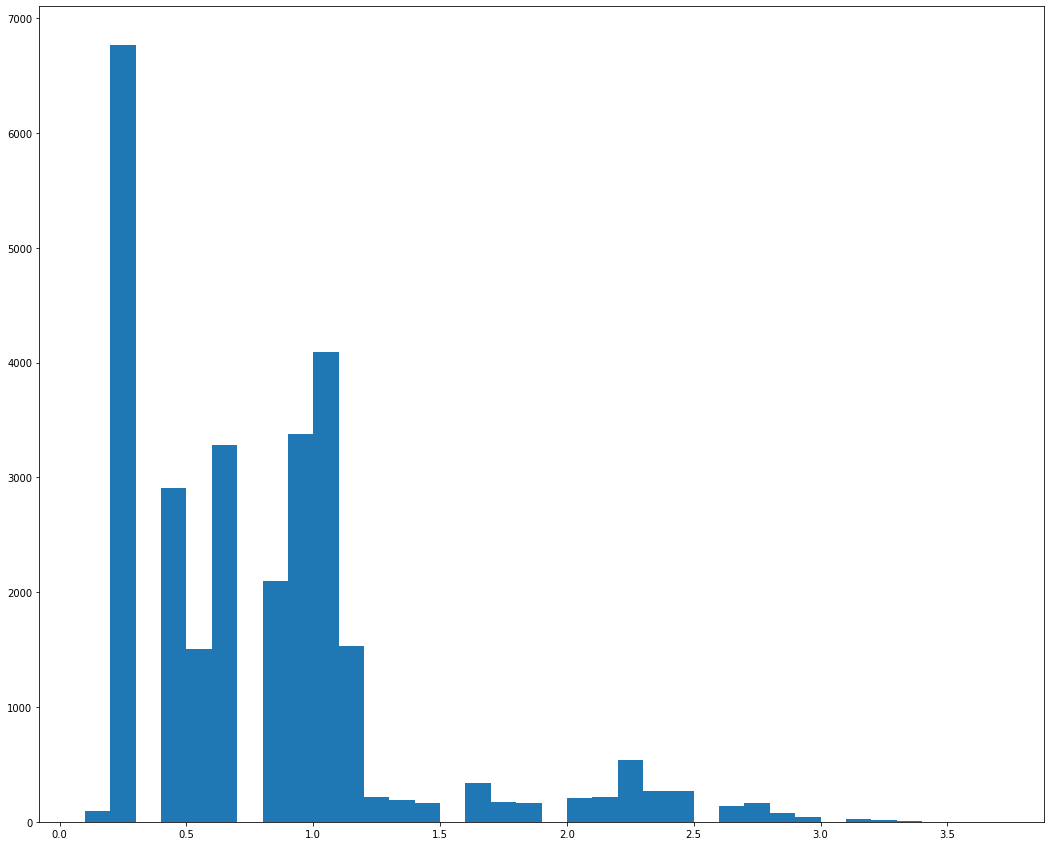

In [45]:
plt.hist(res, bins=36, alpha=1)


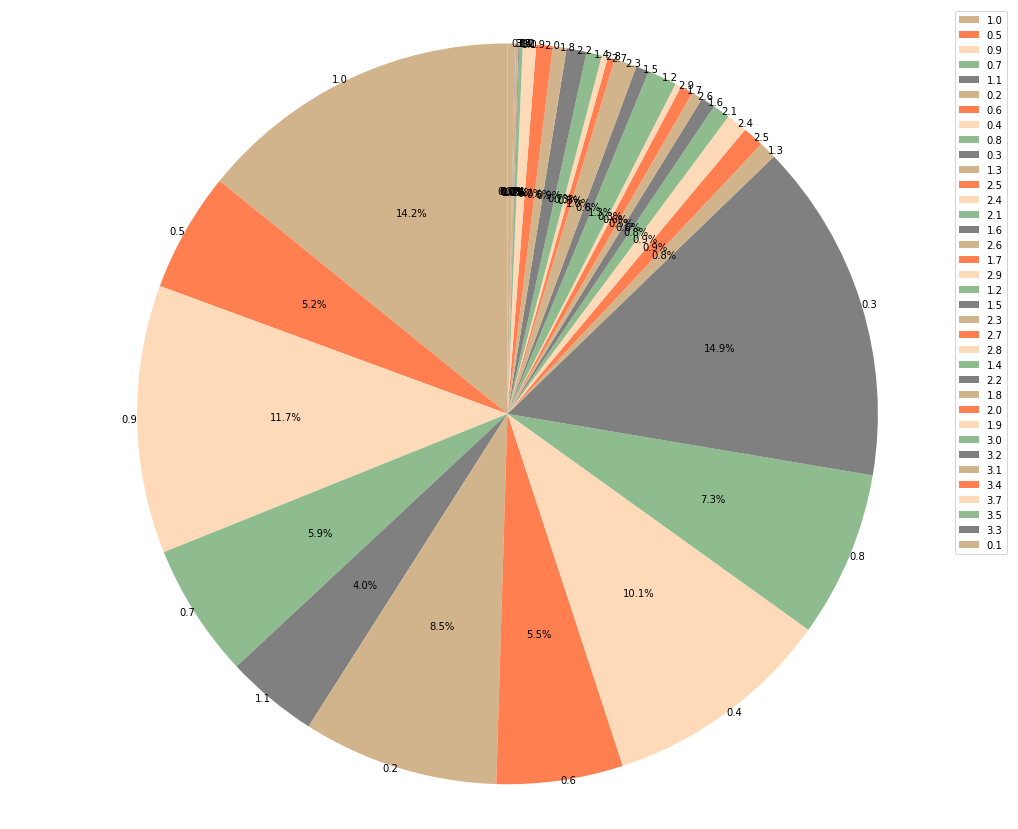

In [42]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

label_list = dic.keys()    # 各部分标签
size = dic.values()    # 各部分大小
color = ["tan", "coral", "peachpuff",'darkseagreen','grey']     # 各部分颜色
"""
绘制饼图
explode：设置各部分突出
label:设置各部分标签
labeldistance:设置标签文本距圆心位置，1.1表示1.1倍半径
autopct：设置圆里面文本
shadow：设置是否有阴影
startangle：起始角度，默认从0开始逆时针转
pctdistance：设置圆内文本距圆心距离
返回值
l_text：圆内部文本，matplotlib.text.Text object
p_text：圆外部文本
"""
plt.rcParams['figure.figsize'] = (18.0, 15.0)
patches, l_text, p_text = plt.pie(size, colors=color, labels=label_list, labeldistance=1, autopct="%1.1f%%", shadow=False, startangle=90, pctdistance=0.6)
plt.axis("equal")    # 设置横轴和纵轴大小相等，这样饼才是圆的
plt.legend()
plt.show()

In [9]:
print(res)

[['bicycle', 129.5, 134.5, 69, 67], ['bicycle', 285.5, 147.5, 69, 145], ['bicycle', 79.5, 142.0, 91, 96], ['bicycle', 34.0, 149.0, 66, 138], ['bicycle', 156.0, 136.0, 64, 66], ['bicycle', 32.0, 124.0, 44, 60], ['bicycle', 195.5, 142.5, 83, 77], ['bicycle', 83.0, 131.5, 68, 71], ['human', 223.5, 148.0, 37, 172], ['bicycle', 24.5, 123.5, 43, 71], ['bicycle', 13.5, 119.5, 25, 67], ['bicycle', 18.5, 123.0, 35, 66], ['bicycle', 124.0, 134.0, 68, 64], ['bicycle', 45.5, 128.5, 55, 71], ['bicycle', 33.5, 124.0, 51, 72], ['bicycle', 282.5, 148.0, 75, 74], ['bicycle', 265.0, 144.5, 76, 75], ['bicycle', 116.5, 133.5, 79, 75], ['bicycle', 94.5, 131.0, 69, 64], ['bicycle', 281.5, 148.5, 77, 75], ['bicycle', 92.0, 131.0, 76, 74], ['bicycle', 62.0, 128.5, 70, 75], ['human', 161.0, 149.0, 38, 174], ['bicycle', 133.5, 137.5, 69, 71], ['human', 286.0, 158.0, 52, 164], ['bicycle', 12.5, 122.5, 23, 65], ['bicycle', 148.5, 135.5, 79, 77], ['bicycle', 14.5, 119.5, 27, 61], ['bicycle', 266.0, 146.5, 84, 75],

In [8]:
N = 4000
x = np.random.random(size=N) * 100
y = np.random.random(size=N) * 100
radii = np.random.random(size=N) * 10
colors = np.array([ [r, g, 150] for r, g in zip(50 + 2*x, 30 + 2*y) ], dtype="uint8")

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter(x, y, marker="square", size=radii,
          fill_color=colors, fill_alpha=0.6,
          line_color=None)

output_file("color_scatter.html", title="color_scatter.py example")

show(p)  # open a browser

In [6]:
x, y, size, colors = [],[],[],[]
x_bi,x_hu,x_car,y_bi,y_hu,y_car=[],[],[],[],[],[]

for i in res:
    x.append(i[1])
    y.append(i[2])
    size.append((i[3]*i[4])/2)
    if i[0]=='human':
        colors.append([252,157,154])#truck','car','bus','escooter','motorbike']
        x_hu.append(i[1])
        y_hu.append(i[2])
    elif i[0]=='bicycle':
        colors.append([249,205,173])
        x_bi.append(i[1])
        y_bi.append(i[2])
    elif i[0]=='car':
        colors.append([131,175,155])
        x_car.append(i[1])
        y_car.append(i[2])
    elif i[0]=='truck':
        colors.append([200,200,150])
    elif i[0]=='bus':
        colors.append([230,100,150])
    elif i[0]=='escooter':
        colors.append([100,50,200])
    elif i[0]=='motorbike':
        colors.append([30,150,150])
    else:
        colors.append([250,250,250])
        
        
        
        

In [7]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter(x, y, radius=1.5,
          fill_color=colors, fill_alpha=0.3,
          line_color=None)

output_file("color_scatter.html", title="color_scatter.py example")

show(p)  # open a browser

In [9]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter(x_bi, y_bi, radius=1.5,
          fill_color=[[249,205,173] for i in range(len(x_bi))], fill_alpha=0.6,
          line_color=None)

output_file("color_scatter_.html", title="bicycle")

show(p)  # open a browser

In [11]:
# Do a K-means to cluster the bicycle points into three part, and 
kmeans = KMeans(n_clusters=3, random_state=0).fit(x_bi)

ValueError: Expected 2D array, got 1D array instead:
array=[129.5 285.5  79.5 ...  25.5 251.5 170. ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [59]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter(x_car, y_car, radius=1.5,
          fill_color=[[131,175,155] for i in range(len(x_car))], fill_alpha=0.6,
          line_color=None)

output_file("color_scatter_.html", title="car")

show(p)  # open a browser

In [60]:
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)

p.scatter(x_hu, y_hu, radius=1.5,
          fill_color=[[252,157,154] for i in range(len(x_hu))], fill_alpha=0.6,
          line_color=None)

output_file("color_scatter_.html", title="car")

show(p)  # open a browser

# Calculate position-speed factor to calibrate kalman filter prediction in tracking

The traffic counter use a fish-eye lens to record videos for object tracking, the huge distortion of the lens and the different perspectives caused by the moving object have a great effect on object tracking. In our assumption as well observation, most objects in the recorded sequences can be seen as moving in a constant velocity in a short path, which is covered by the traffic counter. But the distortion and changing perspectives make the velocity of a moving object to be very unstable, and thus it increase the dificulty for kalman filter to predict the accurate position of the moving object. We will do the statistic and analyse to find a solution, which helps to reduce the effect of len distortion and perspective to the kalman filter prediction.

We separate objects in three categories according to the distance between the moving object and the camera, which are small scale (long distance), middle scale (middle distance) as well big scale (short distance). The heights of objects in the begining or the end of a sequence can reflect the object's scale well. 

Due to the time limit, we take all bicycle class for example to do the analysis.

In [12]:
#take bicycles in the range [0,50] and[270,320]
def parse_xml_filter_bicycle (images_dirs,
          image_set_filenames,
          annotations_dirs=[],
          classes=[],
          include_classes = 'all',
          exclude_truncated=False,
          exclude_difficult=False,
          ret=False,
          verbose=True):
    

    # Set class members.
    images_dirs = images_dirs
    annotations_dirs = annotations_dirs
    image_set_filenames = image_set_filenames
    classes = classes
    include_classes = include_classes

    # Erase data that might have been parsed before.
    filenames = []
    image_ids = []
    labels = []
    eval_neutral = []
    #widthHeightRatio=[]
    anchor_info= []
    names =set()
    for images_dir, image_set_filename, annotations_dir in zip(images_dirs, image_set_filenames, annotations_dirs):
        # Read the image set file that so that we know all the IDs of all the images to be included in the dataset.
        with open(image_set_filename) as f:
            image_ids = [line.strip() for line in f] # Note: These are strings, not integers.
            image_ids += image_ids

        if verbose: it = tqdm(image_ids, desc="Processing image set '{}'".format(os.path.basename(image_set_filename)), file=sys.stdout)
        else: it = image_ids

        # Loop over all images in this dataset.
        for image_id in it:

            filename = '{}'.format(image_id) + '.pgm'#改变为pgm
            filenames.append(os.path.join(images_dir, filename))

            if not annotations_dir is None:
                # Parse the XML file for this image.
                with open(os.path.join(annotations_dir, image_id + '.xml')) as f:
                    soup = BeautifulSoup(f, 'xml')

                folder = soup.folder.text # In case we want to return the folder in addition to the image file name. Relevant for determining which dataset an image belongs to.
                #filename = soup.filename.text

                boxes = [] # We'll store all boxes for this image here.
                eval_neutr = [] # We'll store whether a box is annotated as "difficult" here.
                objects = soup.find_all('object') # Get a list of all objects in this image.

                # Parse the data for each object.
                for obj in objects:
                    class_name = obj.find('name', recursive=False).text
                    names.add(class_name)
                    #print(class_name)
                    class_id = classes.index(class_name)
                    # Check whether this class is supposed to be included in the dataset.
                    if (not include_classes == 'all') and (not class_id in include_classes): continue
                    pose = obj.find('pose', recursive=False).text
                    truncated = int(obj.find('truncated', recursive=False).text)
                    if exclude_truncated and (truncated == 1): continue
                    difficult = int(obj.find('difficult', recursive=False).text)
                    if exclude_difficult and (difficult == 1): continue
                    # Get the bounding box coordinates.
                    bndbox = obj.find('bndbox', recursive=False)
                    xmin = int(bndbox.xmin.text)
                    ymin = int(bndbox.ymin.text)
                    xmax = int(bndbox.xmax.text)
                    ymax = int(bndbox.ymax.text)
                    width = abs(xmax-xmin)
                    height = abs(ymax-ymin)
                    #widthAndHeightRatio = round(width/height,1)
                    #widthHeightRatio.append(widthAndHeightRatio)
                    if class_name =='bicycle':
                        # filter the bicycle in left and right side of the picture
                        if 0<(xmin+xmax)/2<=50 or 270<=(xmin+xmax)/2<320:
                                temp_anchor_info = [class_name,(xmin+xmax)/2,(ymin+ymax)/2,width,height]
                                anchor_info.append(temp_anchor_info)

    dataset_size = len(filenames)
    dataset_indices = np.arange(dataset_size, dtype=np.int32)
    return anchor_info#widthHeightRatio



In [13]:
VOC_2007_images_dir = '../data_index/data/pic/'

# The directories that contain the annotations.
VOC_2007_annotations_dir = '../data_index/data/label/'

VOC_2007_trainval_image_set_filename = '../data_index/data/train.txt'
#VOC_2012_trainval_image_set_filename = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '../data_index/data/val.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
#classes = ['background','human','bicycle','truck','car','bus','motorbike','escooter']
classes = ['background','human','bicycle','truck','car','bus','escooter','motorbike']

res_bicycle = parse_xml_filter_bicycle(images_dirs=[VOC_2007_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

Processing image set 'train.txt': 100%|██████████| 25792/25792 [00:24<00:00, 1037.60it/s]


In [14]:
len(res_bicycle)

5776

### Use k-means to set the scale boundary of small, middle and big object, with the help of which we will separate the objects in different distances.


In [134]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib as mpl
from scipy.optimize import leastsq


In [35]:
input_array = []
for i in res_bicycle:
    input_array.append([0,i[-1]])

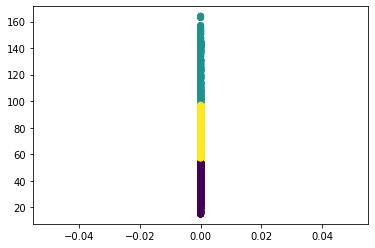

In [30]:
T = np.array(input_array)

y_pred = KMeans(n_clusters=3, random_state=9).fit_predict(T)
plt.scatter(T[:, 0], T[:, 1], c=y_pred)
#plt.scatter(0, input_array[1], c=y_pred)
plt.show()

In [44]:
temp = y_pred.tolist()
print(len(temp))
near = []
middle = []
far =[]
for num,i in enumerate(temp):
    if i==0:
        near.append(input_array[num][1])
    elif i==1:
        far.append(input_array[num][1])
    else:
        middle.append(input_array[num][1])
    

5776


In [46]:
#use the min and max value in the middle scale object list to separate scales
middle_min = min(middle)
middle_max = max(middle)
print(middle_min,middle_max)

55 98


In [107]:
#Filter all sequences that only contain single bicycle, and use these sequence to calculate the position-speed factor.
#Because such bicycle sequences have no occlusion, so that the futher calculation based on clean and complete bicycle sequences
near_seq_list = []
middle_seq_list = []
far_seq_list = []


In [165]:
VOC_2007_images_dir = '../data_index/data/pic/'

# The directories that contain the annotations.
VOC_2007_annotations_dir = '../data_index/data/label/'

VOC_2007_trainval_image_set_filename = '../data_index/data/train.txt'
#VOC_2012_trainval_image_set_filename = '../../datasets/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '../data_index/data/val.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
#classes = ['background','human','bicycle','truck','car','bus','motorbike','escooter']
classes = ['background','bicycle','car']


In [240]:
def parse_xml_with_objList(images_dirs,
          image_ids=[],
          annotations_dirs='',
          classes=[],
          include_classes = 'all',
          exclude_truncated=False,
          exclude_difficult=False,
          ret=False,
          verbose=True):
    
    

    # Set class members.
    images_dirs = images_dirs
    annotations_dirs = annotations_dirs
  
    classes = classes
    include_classes = include_classes

    # Erase data that might have been parsed before.
    filenames = []
    labels = []
    eval_neutral = []
    #widthHeightRatio=[]
    anchor_info= []
    names = set()
    images_dir='../data_index/data/pic/'
    annotations_dir=annotations_dirs
    #print(annotations_dir)
    it = image_ids

        # Loop over all images in this dataset.
    for image_id in it:


        with open(os.path.join(annotations_dir, image_id + '.xml')) as f:
            soup = BeautifulSoup(f, 'xml')

        folder = soup.folder.text # In case we want to return the folder in addition to the image file name. Relevant for determining which dataset an image belongs to.
        #filename = soup.filename.text

        boxes = [] # We'll store all boxes for this image here.
        eval_neutr = [] # We'll store whether a box is annotated as "difficult" here.
        objects = soup.find_all('object') # Get a list of all objects in this image.

        # Parse the data for each object.
        for obj in objects:
            class_name = obj.find('name', recursive=False).text
            if class_name == 'bicycle':
                names.add(class_name)
                #print(class_name)
                class_id = classes.index(class_name)
                # Check whether this class is supposed to be included in the dataset.
                if (not include_classes == 'all') and (not class_id in include_classes): continue
                pose = obj.find('pose', recursive=False).text
                truncated = int(obj.find('truncated', recursive=False).text)
                if exclude_truncated and (truncated == 1): continue
                difficult = int(obj.find('difficult', recursive=False).text)
                if exclude_difficult and (difficult == 1): continue
                # Get the bounding box coordinates.
                bndbox = obj.find('bndbox', recursive=False)
                xmin = int(bndbox.xmin.text)
                ymin = int(bndbox.ymin.text)
                xmax = int(bndbox.xmax.text)
                ymax = int(bndbox.ymax.text)
                width = abs(xmax-xmin)
                height = abs(ymax-ymin)
                #widthAndHeightRatio = round(width/height,1)
                #widthHeightRatio.append(widthAndHeightRatio)

                temp_anchor_info = [class_name,(xmin+xmax)/2,(ymin+ymax)/2,image_id,width,height]
                print(temp_anchor_info)
                anchor_info.append(temp_anchor_info)

    
    return anchor_info#widthHeightRatio

In [243]:
seq_path = '../../Data_orderd_with_name_rules/train_data_object_detection/'
root_dirs = os.listdir(seq_path)
print(len(root_dirs))
# parse all sequences in train set and filter the none single bicycle 
for i in root_dirs:
    sub_dir_path = seq_path+i+'/'
    sequence_dirs = os.listdir(sub_dir_path)
    for j in sequence_dirs:
        if j[-4:]=='0002':
            sequence_frame_list = os.listdir(sub_dir_path+'/'+j)
            temp_list = []
            for k in sequence_frame_list:
                if k[-3:]=='xml':
                    #print(k)
                    temp_list.append(k[:-4])
            temp_list.sort()
            temp_positio_res = parse_xml_with_objList(images_dirs=[VOC_2007_images_dir],
                        image_ids=temp_list,
                        annotations_dirs=sub_dir_path+'/'+j,
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)
            #print(temp_positio_res)
            if len(temp_positio_res)>0:
                if temp_positio_res[0][-1] <55:
                    far_seq_list.append(temp_positio_res)
                elif temp_positio_res[0][-1] >98:
                    near_seq_list.append(temp_positio_res)
                else:
                    middle_seq_list.append(temp_positio_res)
                
                
                
        

32
['bicycle', 313.0, 124.0, '192.168.43.213_1605277241210', 14, 64]
['bicycle', 301.0, 126.0, '192.168.43.213_1605277241464', 32, 66]
['bicycle', 286.0, 128.0, '192.168.43.213_1605277241760', 42, 70]
['bicycle', 261.5, 129.5, '192.168.43.213_1605277242133', 49, 77]
['bicycle', 240.0, 131.0, '192.168.43.213_1605277242277', 58, 86]
['bicycle', 193.5, 134.0, '192.168.43.213_1605277242557', 73, 92]
['bicycle', 172.0, 136.5, '192.168.43.213_1605277242797', 82, 99]
['bicycle', 134.0, 137.5, '192.168.43.213_1605277243054', 94, 107]
['bicycle', 93.5, 138.0, '192.168.43.213_1605277243263', 103, 114]
['bicycle', 56.5, 136.5, '192.168.43.213_1605277243417', 97, 111]
['bicycle', 29.0, 139.0, '192.168.43.213_1605277243603', 56, 112]
['bicycle', 16.0, 138.5, '192.168.43.213_1605277243875', 30, 107]
['bicycle', 312.5, 126.5, '192.168.43.213_1605277081110', 15, 47]
['bicycle', 310.0, 127.5, '192.168.43.213_1605277081295', 20, 51]
['bicycle', 307.5, 126.5, '192.168.43.213_1605277081385', 23, 57]
['bic

['bicycle', 284.0, 152.5, '192.168.43.213_1604568127258', 70, 139]
['bicycle', 302.0, 148.5, '192.168.43.213_1604568127366', 34, 119]
['bicycle', 23.0, 133.5, '192.168.43.213_1604568155477', 44, 103]
['bicycle', 35.0, 137.5, '192.168.43.213_1604568155627', 68, 105]
['bicycle', 73.0, 136.0, '192.168.43.213_1604568155818', 92, 106]
['bicycle', 117.0, 137.5, '192.168.43.213_1604568155928', 90, 101]
['bicycle', 160.0, 135.5, '192.168.43.213_1604568156085', 80, 97]
['bicycle', 198.5, 134.0, '192.168.43.213_1604568156202', 71, 90]
['bicycle', 232.0, 132.5, '192.168.43.213_1604568156348', 64, 87]
['bicycle', 248.5, 133.5, '192.168.43.213_1604568156482', 61, 83]
['bicycle', 274.0, 133.5, '192.168.43.213_1604568156613', 48, 77]
['bicycle', 294.5, 131.5, '192.168.43.213_1604568156747', 37, 71]
['bicycle', 303.0, 131.0, '192.168.43.213_1604568156899', 32, 70]
['bicycle', 310.5, 129.0, '192.168.43.213_1604568157059', 17, 64]
['bicycle', 294.0, 132.5, '192.168.43.213_1604568195032', 20, 31]
['bicyc

['bicycle', 47.0, 127.5, '192.168.43.213_1604565523137', 92, 111]
['bicycle', 79.5, 125.5, '192.168.43.213_1604565523253', 113, 115]
['bicycle', 98.5, 127.0, '192.168.43.213_1604565523365', 113, 114]
['bicycle', 140.5, 126.0, '192.168.43.213_1604565523481', 103, 108]
['bicycle', 161.5, 126.5, '192.168.43.213_1604565523626', 99, 103]
['bicycle', 197.5, 125.0, '192.168.43.213_1604565523773', 87, 98]
['bicycle', 213.0, 125.0, '192.168.43.213_1604565523887', 82, 96]
['bicycle', 241.5, 123.0, '192.168.43.213_1604565524017', 71, 92]
['bicycle', 265.0, 123.5, '192.168.43.213_1604565524120', 52, 85]
['bicycle', 276.5, 123.0, '192.168.43.213_1604565524226', 47, 82]
['bicycle', 290.5, 122.0, '192.168.43.213_1604565524363', 39, 74]
['bicycle', 298.5, 121.5, '192.168.43.213_1604565524499', 33, 71]
['bicycle', 308.0, 121.5, '192.168.43.213_1604565524601', 22, 63]
['bicycle', 311.0, 122.0, '192.168.43.213_1604565524734', 18, 64]
['bicycle', 29.5, 128.0, '192.168.43.213_1604565525093', 57, 124]
['bic

['bicycle', 35.5, 147.0, '192.168.43.213_1604583951556', 69, 114]
['bicycle', 76.0, 145.0, '192.168.43.213_1604583951688', 116, 118]
['bicycle', 105.0, 145.5, '192.168.43.213_1604583951804', 120, 121]
['bicycle', 167.5, 142.5, '192.168.43.213_1604583951904', 113, 119]
['bicycle', 195.0, 140.5, '192.168.43.213_1604583952006', 108, 117]
['bicycle', 222.0, 138.5, '192.168.43.213_1604583952104', 102, 113]
['bicycle', 267.5, 134.5, '192.168.43.213_1604583952219', 77, 111]
['bicycle', 285.0, 132.0, '192.168.43.213_1604583952340', 60, 102]
['bicycle', 297.0, 132.0, '192.168.43.213_1604583952405', 44, 92]
['bicycle', 308.0, 126.0, '192.168.43.213_1604584129639', 24, 36]
['bicycle', 302.5, 129.0, '192.168.43.213_1604584129761', 33, 40]
['bicycle', 280.0, 127.0, '192.168.43.213_1604584129832', 38, 46]
['bicycle', 253.5, 127.5, '192.168.43.213_1604584129997', 49, 49]
['bicycle', 240.0, 127.0, '192.168.43.213_1604584130112', 50, 52]
['bicycle', 209.0, 128.0, '192.168.43.213_1604584130239', 50, 48]

['bicycle', 23.5, 130.5, '192.168.43.213_1604584135758', 27, 33]
['bicycle', 17.5, 131.0, '192.168.43.213_1604584135868', 23, 34]
['bicycle', 8.5, 131.0, '192.168.43.213_1604584135984', 15, 34]
['bicycle', 6.0, 130.5, '192.168.43.213_1604584136084', 10, 33]
['bicycle', 234.0, 122.5, '192.168.43.213_1604583964868', 24, 27]
['bicycle', 229.5, 122.0, '192.168.43.213_1604583964948', 25, 28]
['bicycle', 221.0, 123.0, '192.168.43.213_1604583965111', 26, 28]
['bicycle', 217.0, 122.5, '192.168.43.213_1604583965189', 26, 31]
['bicycle', 208.0, 123.5, '192.168.43.213_1604583965337', 28, 29]
['bicycle', 203.0, 124.5, '192.168.43.213_1604583965412', 28, 27]
['bicycle', 198.0, 123.0, '192.168.43.213_1604583965500', 28, 28]
['bicycle', 194.0, 123.5, '192.168.43.213_1604583965578', 28, 27]
['bicycle', 189.5, 124.5, '192.168.43.213_1604583965664', 27, 29]
['bicycle', 185.0, 125.0, '192.168.43.213_1604583965795', 26, 26]
['bicycle', 174.0, 125.5, '192.168.43.213_1604583965928', 26, 27]
['bicycle', 171.

['bicycle', 21.0, 133.5, '192.168.43.211_1596987425527', 40, 97]
['bicycle', 34.5, 134.0, '192.168.43.211_1596987425639', 67, 100]
['bicycle', 79.5, 137.0, '192.168.43.211_1596987425737', 99, 98]
['bicycle', 107.5, 137.5, '192.168.43.211_1596987425831', 101, 97]
['bicycle', 136.5, 139.0, '192.168.43.211_1596987425897', 97, 94]
['bicycle', 164.5, 139.0, '192.168.43.211_1596987425994', 89, 92]
['bicycle', 191.5, 140.0, '192.168.43.211_1596987426048', 81, 88]
['bicycle', 212.5, 141.0, '192.168.43.211_1596987426146', 77, 86]
['bicycle', 233.5, 142.0, '192.168.43.211_1596987426223', 69, 82]
['bicycle', 253.5, 142.5, '192.168.43.211_1596987426289', 65, 81]
['bicycle', 273.5, 141.5, '192.168.43.211_1596987426395', 57, 77]
['bicycle', 287.5, 143.0, '192.168.43.211_1596987426443', 55, 72]
['bicycle', 292.0, 145.0, '192.168.43.211_1596987426554', 56, 72]
['bicycle', 33.5, 147.5, '192.168.43.211_1596986833419', 65, 151]
['bicycle', 47.5, 149.5, '192.168.43.211_1596986833514', 93, 157]
['bicycle',

['bicycle', 85.0, 128.5, '192.168.43.213_1604567673931', 42, 41]
['bicycle', 65.5, 129.0, '192.168.43.213_1604567674048', 43, 42]
['bicycle', 55.0, 130.5, '192.168.43.213_1604567674191', 42, 41]
['bicycle', 36.5, 128.5, '192.168.43.213_1604567674324', 39, 41]
['bicycle', 19.5, 130.0, '192.168.43.213_1604567674417', 33, 42]
['bicycle', 14.5, 129.5, '192.168.43.213_1604567674562', 27, 41]
['bicycle', 290.5, 150.5, '192.168.43.211_1596990115867', 59, 79]
['bicycle', 282.5, 148.0, '192.168.43.211_1596990115950', 75, 74]
['bicycle', 270.5, 146.5, '192.168.43.211_1596990116039', 87, 77]
['bicycle', 249.5, 144.0, '192.168.43.211_1596990116148', 83, 76]
['bicycle', 216.0, 143.0, '192.168.43.211_1596990116243', 84, 78]
['bicycle', 198.5, 140.5, '192.168.43.211_1596990116348', 79, 81]
['bicycle', 182.0, 140.0, '192.168.43.211_1596990116435', 78, 78]
['bicycle', 166.0, 138.0, '192.168.43.211_1596990116513', 76, 78]
['bicycle', 148.5, 135.5, '192.168.43.211_1596990116584', 79, 77]
['bicycle', 132.

['bicycle', 154.5, 128.5, '192.168.43.213_1604583169560', 31, 37]
['bicycle', 146.5, 129.5, '192.168.43.213_1604583169640', 33, 39]
['bicycle', 137.5, 129.5, '192.168.43.213_1604583169773', 35, 41]
['bicycle', 120.5, 131.0, '192.168.43.213_1604583169883', 37, 38]
['bicycle', 110.0, 131.5, '192.168.43.213_1604583169978', 36, 41]
['bicycle', 100.0, 133.0, '192.168.43.213_1604583170076', 38, 40]
['bicycle', 80.5, 132.0, '192.168.43.213_1604583170198', 41, 40]
['bicycle', 70.5, 134.0, '192.168.43.213_1604583170278', 39, 40]
['bicycle', 61.0, 133.5, '192.168.43.213_1604583170414', 38, 39]
['bicycle', 42.5, 134.0, '192.168.43.213_1604583170530', 35, 42]
['bicycle', 34.0, 135.0, '192.168.43.213_1604583170631', 32, 40]
['bicycle', 18.0, 135.5, '192.168.43.213_1604583170766', 30, 39]
['bicycle', 12.0, 136.0, '192.168.43.213_1604583170870', 22, 40]
['bicycle', 38.5, 133.5, '192.168.43.213_1604582119352', 75, 101]
['bicycle', 51.0, 133.0, '192.168.43.213_1604582119455', 92, 100]
['bicycle', 68.5,

['bicycle', 81.0, 130.5, '192.168.43.213_1604584339497', 32, 31]
['bicycle', 75.0, 130.5, '192.168.43.213_1604584339587', 32, 31]
['bicycle', 69.5, 130.0, '192.168.43.213_1604584339692', 31, 32]
['bicycle', 58.5, 131.0, '192.168.43.213_1604584339829', 27, 30]
['bicycle', 54.0, 130.5, '192.168.43.213_1604584339915', 28, 31]
['bicycle', 43.5, 130.5, '192.168.43.213_1604584340063', 27, 31]
['bicycle', 38.5, 131.0, '192.168.43.213_1604584340129', 25, 30]
['bicycle', 34.5, 130.5, '192.168.43.213_1604584340216', 25, 29]
['bicycle', 29.5, 130.0, '192.168.43.213_1604584340286', 23, 30]
['bicycle', 25.0, 130.5, '192.168.43.213_1604584340359', 24, 29]
['bicycle', 21.5, 130.5, '192.168.43.213_1604584340456', 21, 29]
['bicycle', 17.5, 130.0, '192.168.43.213_1604584340520', 21, 28]
['bicycle', 13.0, 130.0, '192.168.43.213_1604584340621', 18, 28]
['bicycle', 10.5, 130.5, '192.168.43.213_1604584340686', 19, 27]
['bicycle', 8.5, 130.0, '192.168.43.213_1604584340772', 15, 26]
['bicycle', 313.0, 125.0, 

['bicycle', 308.0, 119.0, '192.168.43.213_1605349193062', 24, 44]
['bicycle', 311.0, 119.5, '192.168.43.213_1605349193198', 18, 43]
['bicycle', 313.5, 121.0, '192.168.43.213_1605349193307', 13, 40]
['bicycle', 298.5, 121.0, '192.168.43.213_1605349050818', 37, 56]
['bicycle', 290.0, 123.0, '192.168.43.213_1605349050920', 40, 58]
['bicycle', 270.0, 123.5, '192.168.43.213_1605349051034', 48, 59]
['bicycle', 258.0, 123.5, '192.168.43.213_1605349051120', 52, 61]
['bicycle', 245.5, 124.0, '192.168.43.213_1605349051237', 55, 60]
['bicycle', 219.0, 125.0, '192.168.43.213_1605349051361', 60, 60]
['bicycle', 205.0, 125.5, '192.168.43.213_1605349051437', 58, 61]
['bicycle', 178.0, 126.0, '192.168.43.213_1605349051614', 58, 60]
['bicycle', 163.0, 126.5, '192.168.43.213_1605349051682', 60, 63]
['bicycle', 133.5, 128.5, '192.168.43.213_1605349051850', 63, 65]
['bicycle', 117.5, 128.5, '192.168.43.213_1605349051978', 65, 65]
['bicycle', 88.0, 129.5, '192.168.43.213_1605349052088', 68, 67]
['bicycle',

['bicycle', 159.0, 129.5, '192.168.43.213_1605351084810', 28, 27]
['bicycle', 149.5, 129.5, '192.168.43.213_1605351084935', 29, 27]
['bicycle', 146.0, 129.0, '192.168.43.213_1605351085014', 28, 28]
['bicycle', 137.0, 129.5, '192.168.43.213_1605351085163', 32, 29]
['bicycle', 133.0, 131.0, '192.168.43.213_1605351085240', 32, 30]
['bicycle', 127.0, 130.5, '192.168.43.213_1605351085327', 34, 31]
['bicycle', 123.0, 130.0, '192.168.43.213_1605351085418', 32, 30]
['bicycle', 118.0, 130.5, '192.168.43.213_1605351085538', 32, 31]
['bicycle', 108.5, 130.0, '192.168.43.213_1605351085643', 33, 32]
['bicycle', 104.0, 131.0, '192.168.43.213_1605351085718', 34, 32]
['bicycle', 98.5, 130.5, '192.168.43.213_1605351085822', 35, 33]
['bicycle', 94.0, 130.0, '192.168.43.213_1605351085928', 36, 34]
['bicycle', 84.5, 131.5, '192.168.43.213_1605351086053', 35, 33]
['bicycle', 79.5, 131.5, '192.168.43.213_1605351086135', 35, 33]
['bicycle', 74.5, 130.5, '192.168.43.213_1605351086223', 33, 33]
['bicycle', 64.

['bicycle', 277.5, 128.0, '192.168.43.213_1605277818525', 33, 54]
['bicycle', 292.5, 126.5, '192.168.43.213_1605277818668', 25, 51]
['bicycle', 299.5, 127.0, '192.168.43.213_1605277818755', 23, 48]
['bicycle', 310.5, 125.5, '192.168.43.213_1605277818939', 19, 47]
['bicycle', 312.5, 125.5, '192.168.43.213_1605277819037', 15, 45]
['bicycle', 314.5, 125.5, '192.168.43.213_1605278002750', 11, 31]
['bicycle', 312.5, 126.0, '192.168.43.213_1605278002820', 15, 32]
['bicycle', 305.5, 125.5, '192.168.43.213_1605278002974', 15, 33]
['bicycle', 302.5, 126.5, '192.168.43.213_1605278003055', 19, 35]
['bicycle', 297.5, 128.0, '192.168.43.213_1605278003131', 19, 34]
['bicycle', 293.5, 127.5, '192.168.43.213_1605278003225', 19, 37]
['bicycle', 288.5, 128.0, '192.168.43.213_1605278003359', 23, 36]
['bicycle', 277.5, 128.0, '192.168.43.213_1605278003481', 25, 36]
['bicycle', 271.0, 128.5, '192.168.43.213_1605278003577', 28, 39]
['bicycle', 256.5, 127.5, '192.168.43.213_1605278003704', 33, 41]
['bicycle'

['bicycle', 83.5, 139.0, '192.168.43.213_1605271627215', 89, 98]
['bicycle', 106.0, 139.0, '192.168.43.213_1605271627367', 92, 98]
['bicycle', 151.5, 138.5, '192.168.43.213_1605271627533', 93, 95]
['bicycle', 198.0, 138.0, '192.168.43.213_1605271627696', 92, 98]
['bicycle', 238.5, 137.0, '192.168.43.213_1605271627813', 79, 98]
['bicycle', 274.0, 133.5, '192.168.43.213_1605271627917', 60, 95]
['bicycle', 300.0, 129.5, '192.168.43.213_1605271628043', 40, 89]
['bicycle', 307.0, 129.0, '192.168.43.213_1605271628216', 24, 84]
['bicycle', 23.0, 139.5, '192.168.43.213_1605272144452', 44, 97]
['bicycle', 47.0, 140.0, '192.168.43.213_1605272144607', 74, 104]
['bicycle', 67.0, 140.5, '192.168.43.213_1605272144710', 84, 109]
['bicycle', 87.0, 139.5, '192.168.43.213_1605272144781', 92, 107]
['bicycle', 129.0, 139.5, '192.168.43.213_1605272144943', 100, 109]
['bicycle', 153.5, 138.0, '192.168.43.213_1605272145034', 103, 110]
['bicycle', 200.5, 136.5, '192.168.43.213_1605272145184', 101, 107]
['bicy

['bicycle', 291.5, 131.0, '192.168.43.213_1604567026631', 29, 60]
['bicycle', 294.5, 130.0, '192.168.43.213_1604567026711', 25, 58]
['bicycle', 301.5, 129.5, '192.168.43.213_1604567026869', 23, 55]
['bicycle', 304.0, 128.0, '192.168.43.213_1604567026967', 22, 54]
['bicycle', 309.0, 127.5, '192.168.43.213_1604567027082', 20, 51]
['bicycle', 310.5, 128.0, '192.168.43.213_1604567027207', 17, 52]
['bicycle', 312.0, 127.0, '192.168.43.213_1604567027312', 16, 50]
['bicycle', 33.0, 136.0, '192.168.43.213_1604567191104', 64, 108]
['bicycle', 45.0, 135.5, '192.168.43.213_1604567191211', 88, 105]
['bicycle', 84.0, 135.0, '192.168.43.213_1604567191349', 104, 106]
['bicycle', 105.0, 135.5, '192.168.43.213_1604567191440', 106, 103]
['bicycle', 151.5, 138.5, '192.168.43.213_1604567191584', 103, 101]
['bicycle', 173.0, 138.0, '192.168.43.213_1604567191690', 96, 98]
['bicycle', 210.0, 136.5, '192.168.43.213_1604567191816', 86, 95]
['bicycle', 228.0, 137.0, '192.168.43.213_1604567191930', 80, 94]
['bic

['bicycle', 152.5, 150.5, '192.168.43.211_1596959684357', 107, 111]
['bicycle', 171.0, 149.5, '192.168.43.211_1596959684439', 104, 113]
['bicycle', 189.0, 148.0, '192.168.43.211_1596959684550', 104, 110]
['bicycle', 209.5, 148.0, '192.168.43.211_1596959684640', 103, 110]
['bicycle', 244.5, 146.5, '192.168.43.211_1596959684779', 103, 109]
['bicycle', 260.5, 147.0, '192.168.43.211_1596959684857', 97, 108]
['bicycle', 284.0, 148.0, '192.168.43.211_1596959685027', 72, 108]
['bicycle', 292.0, 143.5, '192.168.43.211_1596959685131', 56, 97]
['bicycle', 60.0, 134.5, '192.168.43.213_1604566316212', 118, 167]
['bicycle', 102.5, 130.0, '192.168.43.213_1604566316361', 159, 174]
['bicycle', 134.5, 129.0, '192.168.43.213_1604566316449', 153, 170]
['bicycle', 196.0, 127.0, '192.168.43.213_1604566316584', 118, 152]
['bicycle', 219.0, 126.0, '192.168.43.213_1604566316730', 106, 144]
['bicycle', 256.5, 123.5, '192.168.43.213_1604566316821', 77, 127]
['bicycle', 271.5, 124.0, '192.168.43.213_160456631691

In [239]:
print(near_seq_list)
print(len(middle_seq_list))
print(len(far_seq_list))


[['bicycle', 56.0, 150.5, 110, 141], ['bicycle', 98.5, 149.5, 141, 139], ['bicycle', 126.5, 151.5, 139, 137], ['bicycle', 181.5, 152.5, 129, 135], ['bicycle', 228.5, 148.5, 109, 127], ['bicycle', 248.5, 148.0, 97, 124], ['bicycle', 282.0, 145.5, 68, 113], ['bicycle', 293.5, 143.5, 51, 105]]
711
550


In [244]:
# reorder every sequence to the same moving direction from left to right(infrom 0 to 320)
#separate sequence in different directions
near_seq_list_l2r = []
near_seq_list_r2l = []
middle_seq_list_l2r = []
middle_seq_list_r2l = []
far_seq_list_l2r = []
far_seq_list_r2l = []
all_seq = [near_seq_list, middle_seq_list, far_seq_list]
for num,i in enumerate(all_seq):
    for seq_list in i:
        #print(seq_list)
        if seq_list[0][1]>160:
            if num==0:
                near_seq_list_r2l.append(seq_list)
            elif num==1:
                middle_seq_list_r2l.append(seq_list)
            else:
                far_seq_list_r2l.append(seq_list)
        else:
            if num==0:
                near_seq_list_l2r.append(seq_list)
            elif num==1:
                middle_seq_list_l2r.append(seq_list)
            else:
                far_seq_list_l2r.append(seq_list)
            
            
#print(all_seq[0])
                    
                    
    

In [245]:
near_seq_list = all_seq[0]
middle_seq_list = all_seq[1]
far_seq_list = all_seq[2]

In [246]:
for i in middle_seq_list_r2l:
    print(i,'\n')

[['bicycle', 313.0, 124.0, 14, 64], ['bicycle', 301.0, 126.0, 32, 66], ['bicycle', 286.0, 128.0, 42, 70], ['bicycle', 261.5, 129.5, 49, 77], ['bicycle', 240.0, 131.0, 58, 86], ['bicycle', 193.5, 134.0, 73, 92], ['bicycle', 172.0, 136.5, 82, 99], ['bicycle', 134.0, 137.5, 94, 107], ['bicycle', 93.5, 138.0, 103, 114], ['bicycle', 56.5, 136.5, 97, 111], ['bicycle', 29.0, 139.0, 56, 112], ['bicycle', 16.0, 138.5, 30, 107]] 

[['bicycle', 304.0, 126.5, 32, 63], ['bicycle', 299.0, 127.5, 42, 67], ['bicycle', 294.0, 128.0, 52, 68], ['bicycle', 288.0, 127.5, 64, 67], ['bicycle', 273.5, 128.5, 59, 69], ['bicycle', 262.0, 127.5, 64, 69], ['bicycle', 250.0, 128.0, 66, 68], ['bicycle', 238.5, 128.0, 67, 68], ['bicycle', 225.5, 128.5, 71, 67], ['bicycle', 213.0, 129.0, 72, 66], ['bicycle', 201.5, 129.0, 67, 66], ['bicycle', 188.0, 129.5, 66, 65], ['bicycle', 176.0, 129.5, 60, 63], ['bicycle', 164.0, 129.5, 60, 61], ['bicycle', 152.0, 129.5, 60, 61], ['bicycle', 142.0, 129.5, 58, 61], ['bicycle', 13

In [221]:
#the result format is like [(x1,factor1),(x2,factor2)...]
def calculate_speedPosision_factor(seq_list,hypothesis='1'):
    result_list = []
    for num,i in enumerate(seq_list):
        seq_result = []
        last_factor = 0
        for num_detect,j in enumerate(i):
            if num_detect ==0 or num_detect==len(i)-1:
                seq_result.append([j[1],1])
            else:
                if hypothesis=='1':
                    # the ratio reflects the distance of the current object to the position in next frame and the distance to the position in previous frame.
                    factor = round((i[num_detect+1][1]-i[num_detect][1])/(i[num_detect][1]-i[num_detect-1][1]),2)
                else:
                    # the ratio reflects the distance of the current object to the position in next frame and the average distance of this kind of object per frame.
                    factor = round((i[num_detect+1][1]-i[num_detect][1])/(320/max(2,len(i)-1)),2)
                if abs(factor)>4 or abs(factor)<0.25:
                    factor = last_factor
                    
                seq_result.append([j[1],factor])
                last_factor = factor
        result_list.append(seq_result)
    return result_list
    

In [203]:
# result of hypothesis 1
near_seq_factor_l2r = calculate_speedPosision_factor(near_seq_list_l2r)
middle_seq_factor_l2r = calculate_speedPosision_factor(middle_seq_list_l2r)
far_seq_factor_l2r = calculate_speedPosision_factor(far_seq_list_l2r)

near_seq_factor_r2l = calculate_speedPosision_factor(near_seq_list_r2l)
middle_seq_factor_r2l = calculate_speedPosision_factor(middle_seq_list_r2l)
far_seq_factor_r2l = calculate_speedPosision_factor(far_seq_list_r2l)


In [218]:
for i in range(len(near_seq_list_l2r)):
    
    print(near_seq_list_l2r[i],'\n')
    print(near_seq_factor_l2r[i],'\n')

[['bicycle', 56.0, 150.5, 110, 141], ['bicycle', 98.5, 149.5, 141, 139], ['bicycle', 126.5, 151.5, 139, 137], ['bicycle', 181.5, 152.5, 129, 135], ['bicycle', 228.5, 148.5, 109, 127], ['bicycle', 248.5, 148.0, 97, 124], ['bicycle', 282.0, 145.5, 68, 113], ['bicycle', 293.5, 143.5, 51, 105]] 

[[56.0, 1], [98.5, 0.66], [126.5, 1.96], [181.5, 0.85], [228.5, 0.43], [248.5, 1.68], [282.0, 0.34], [293.5, 1]] 

[['bicycle', 50.0, 156.5, 98, 163], ['bicycle', 82.5, 153.5, 163, 171], ['bicycle', 106.5, 153.5, 177, 171], ['bicycle', 160.0, 155.5, 170, 167], ['bicycle', 187.0, 156.0, 158, 166], ['bicycle', 235.5, 157.0, 125, 164], ['bicycle', 271.5, 152.5, 97, 147], ['bicycle', 284.0, 152.5, 70, 139], ['bicycle', 302.0, 148.5, 34, 119]] 

[[50.0, 1], [82.5, 0.74], [106.5, 2.23], [160.0, 0.5], [187.0, 1.8], [235.5, 0.74], [271.5, 0.35], [284.0, 1.44], [302.0, 1]] 

[['bicycle', 23.0, 133.5, 44, 103], ['bicycle', 35.0, 137.5, 68, 105], ['bicycle', 73.0, 136.0, 92, 106], ['bicycle', 117.0, 137.5, 9

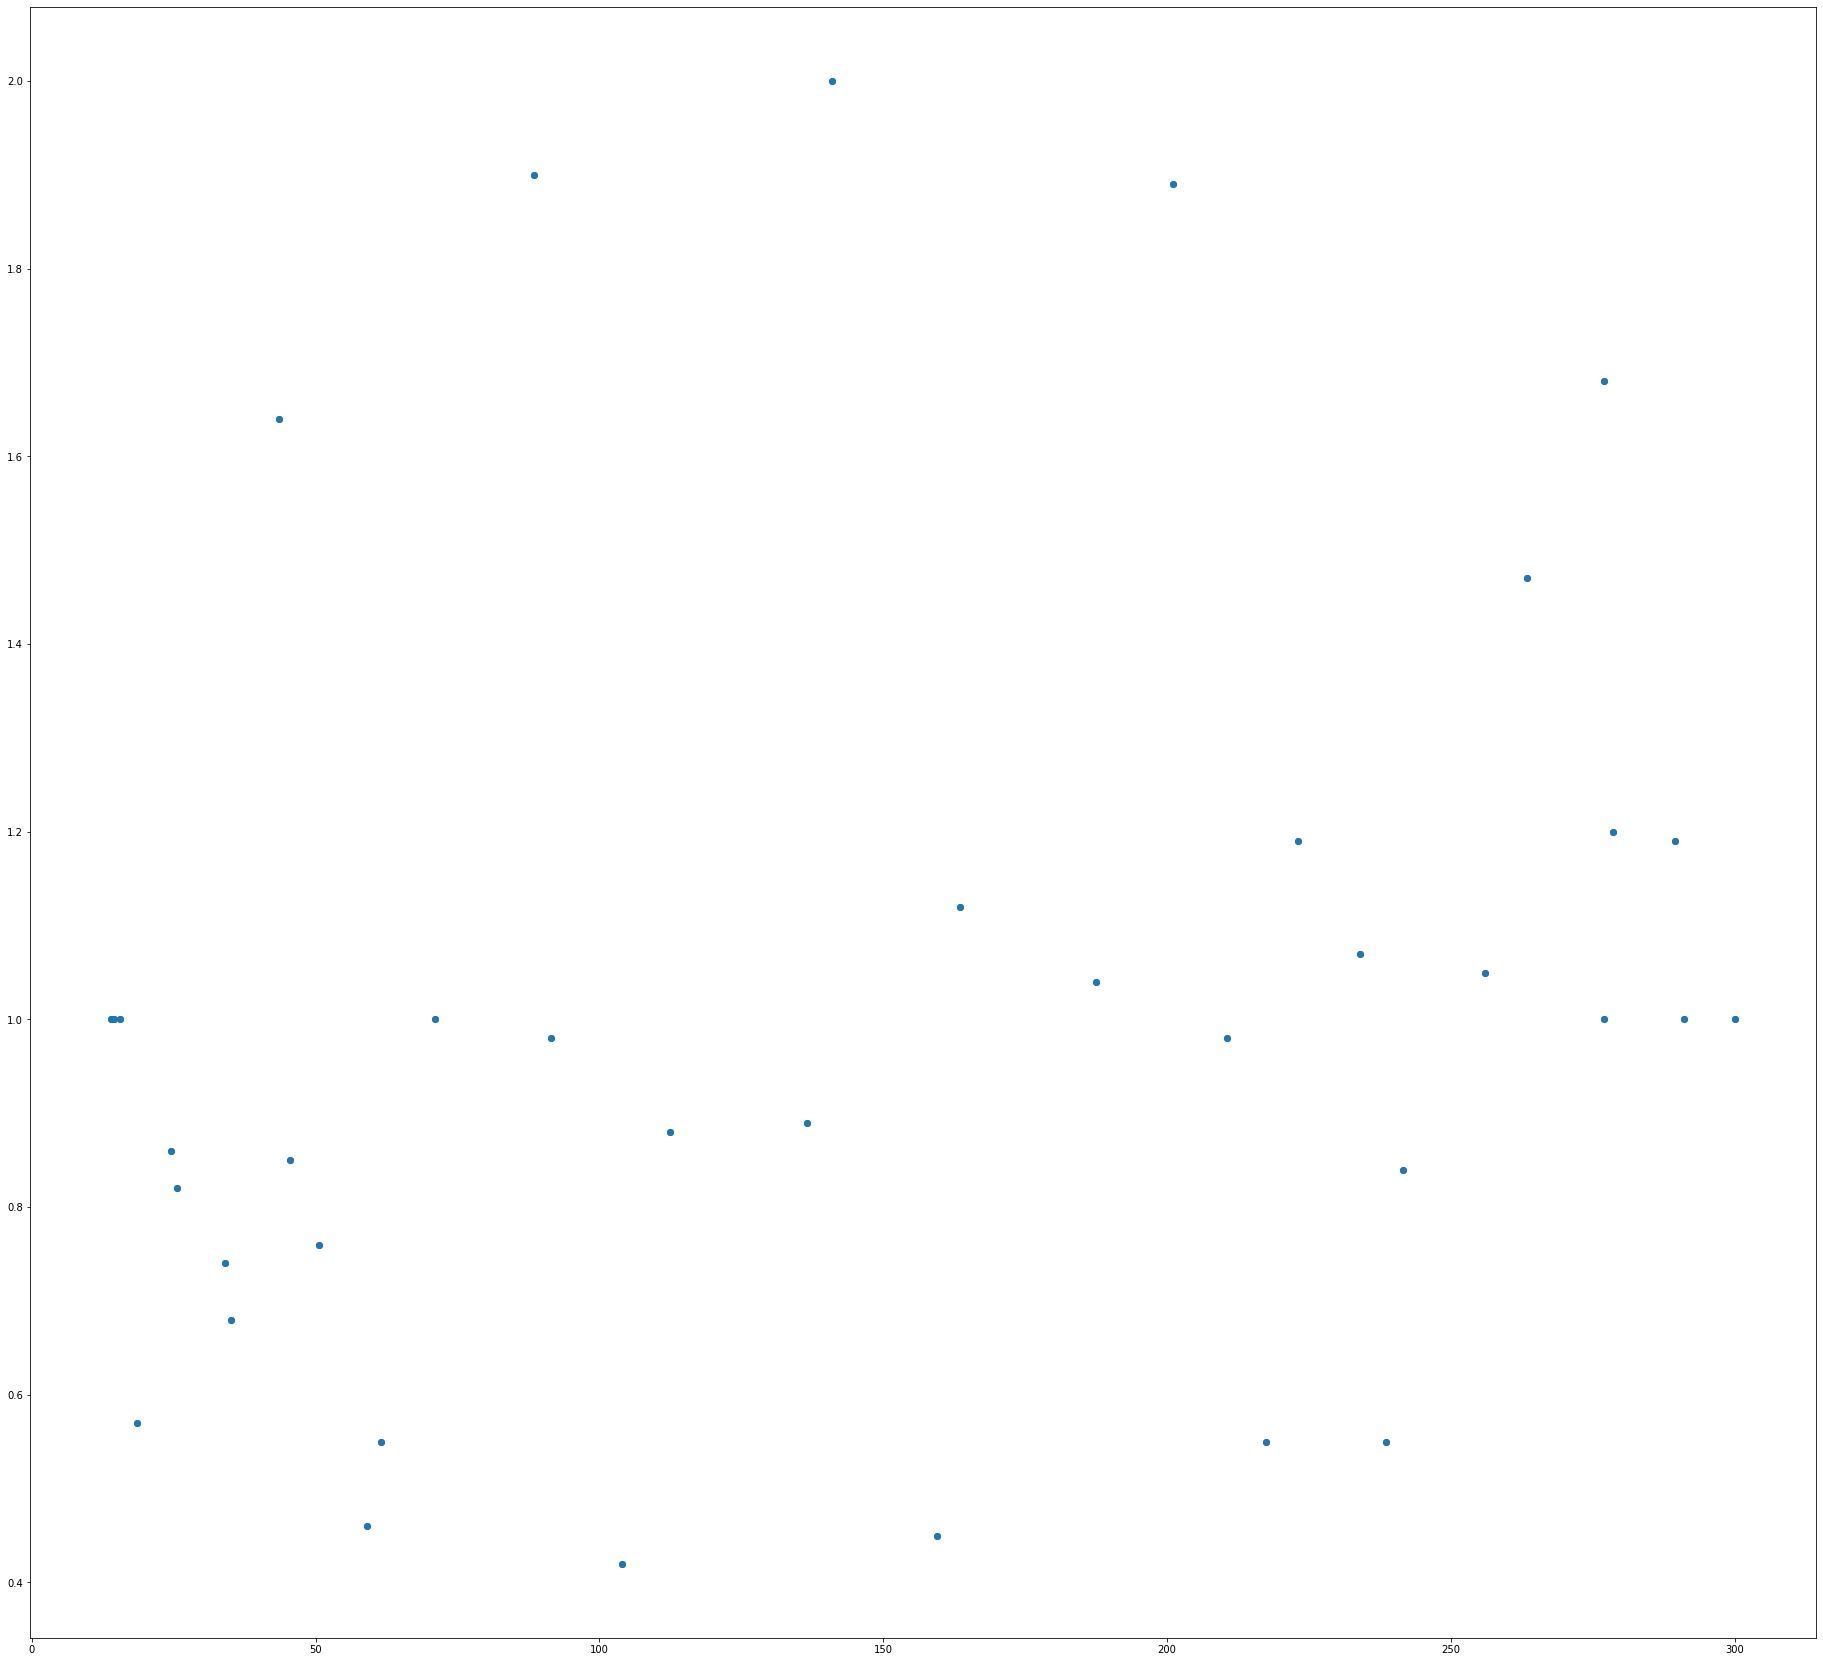

In [231]:
x,y = [],[]

for i in near_seq_factor_r2l:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.scatter(x,y)

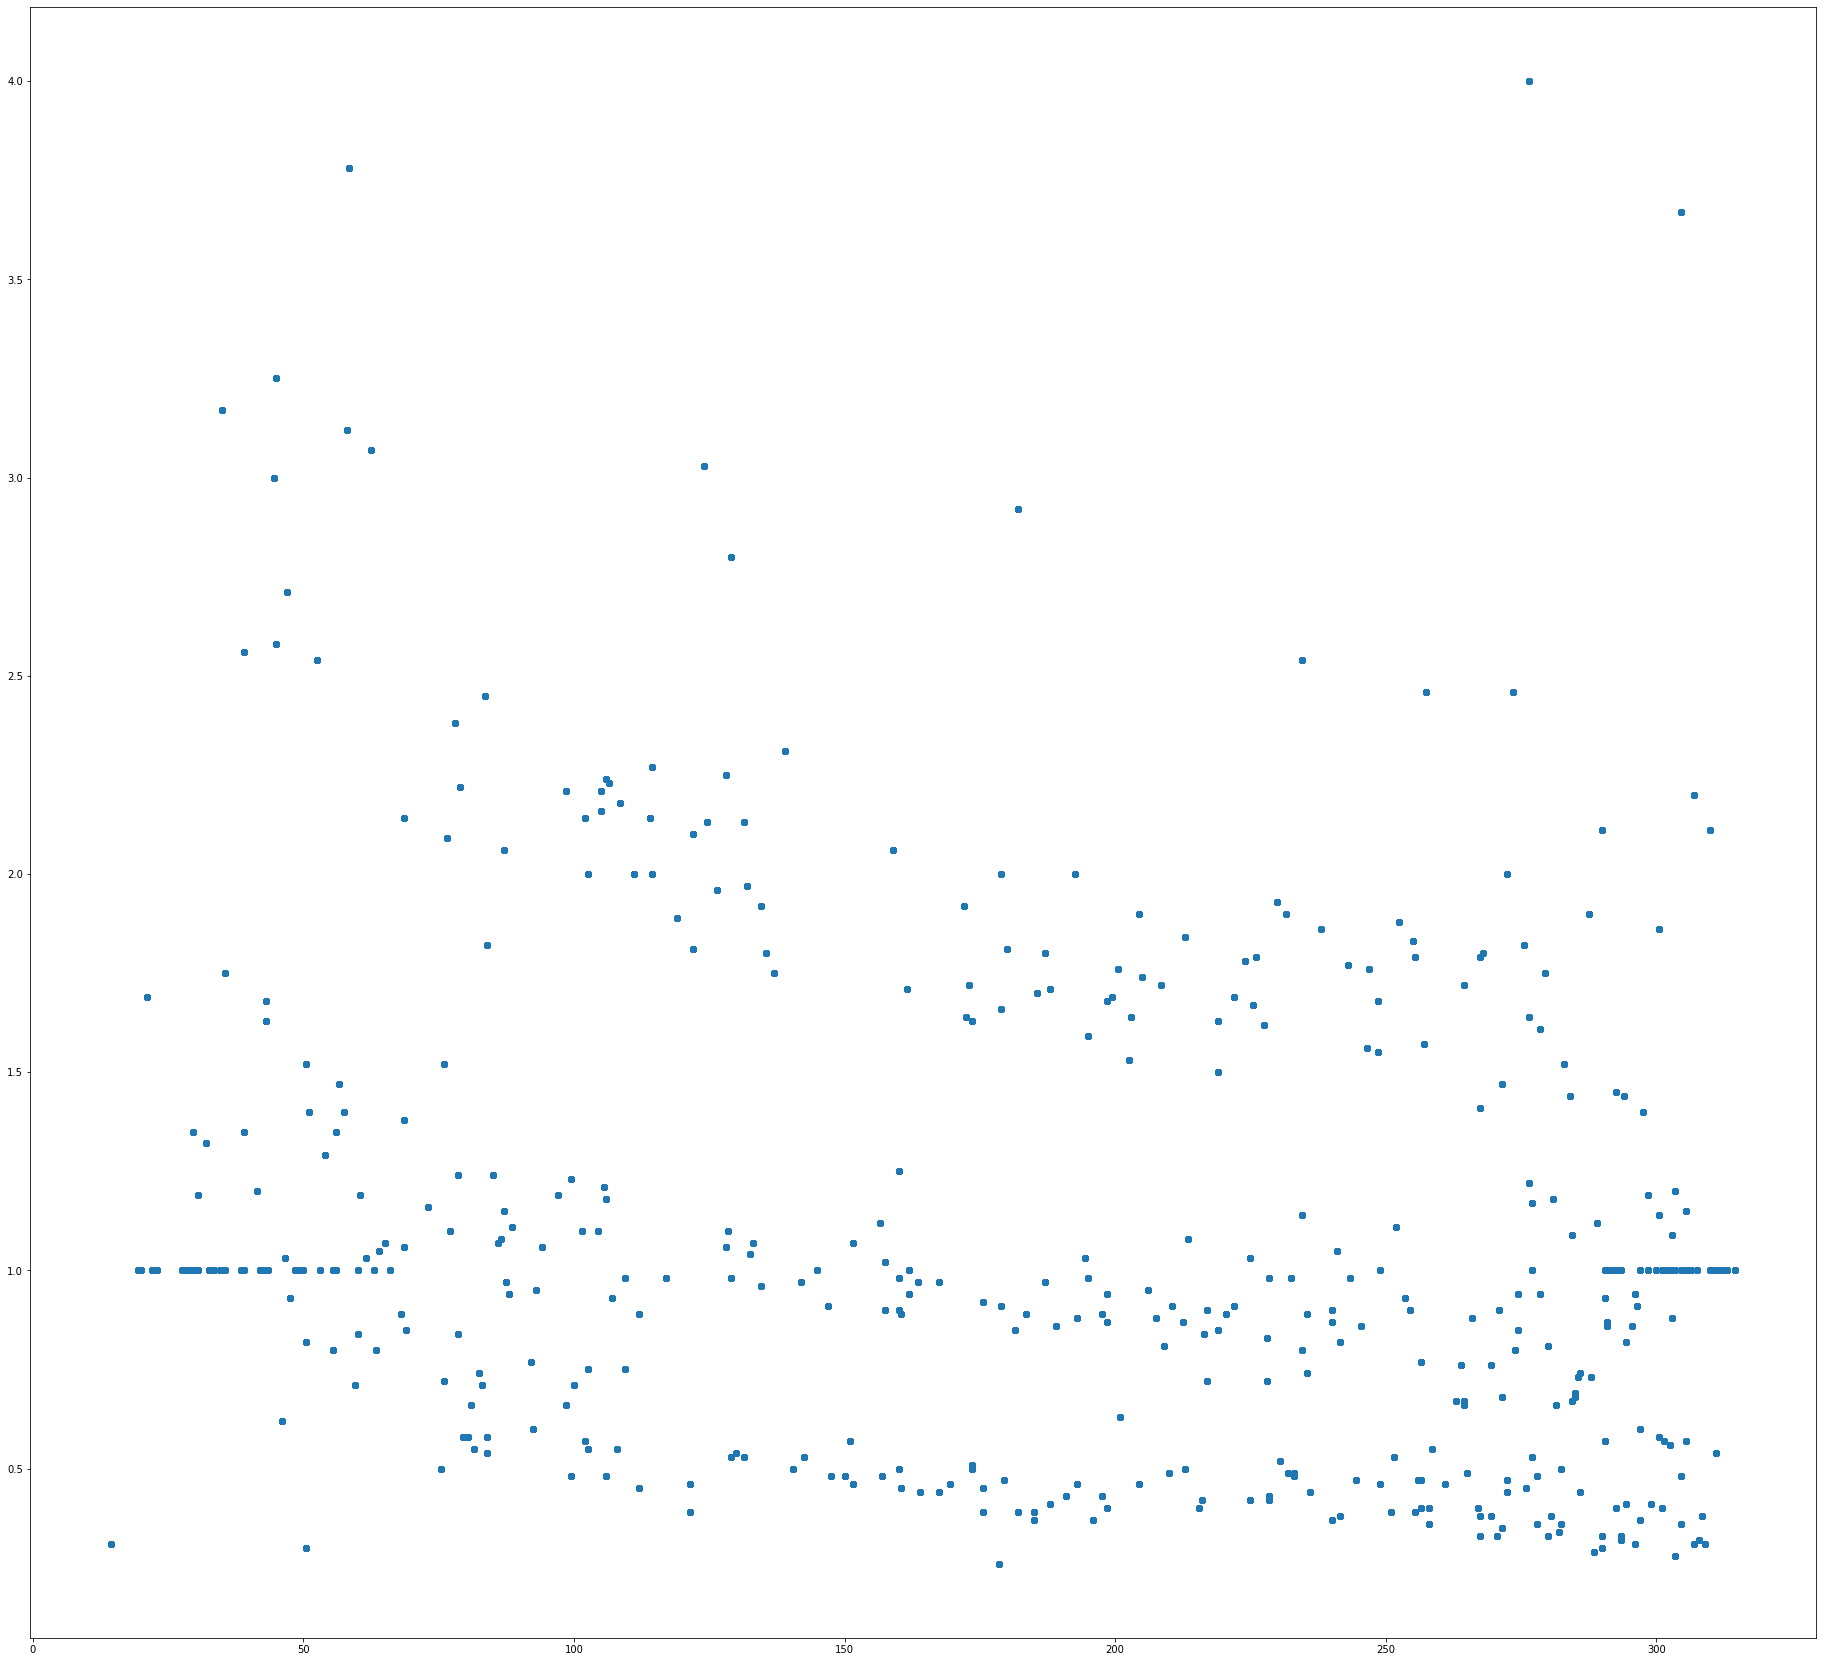

In [232]:
x,y = [],[]
for i in near_seq_factor_l2r:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.scatter(x,y)

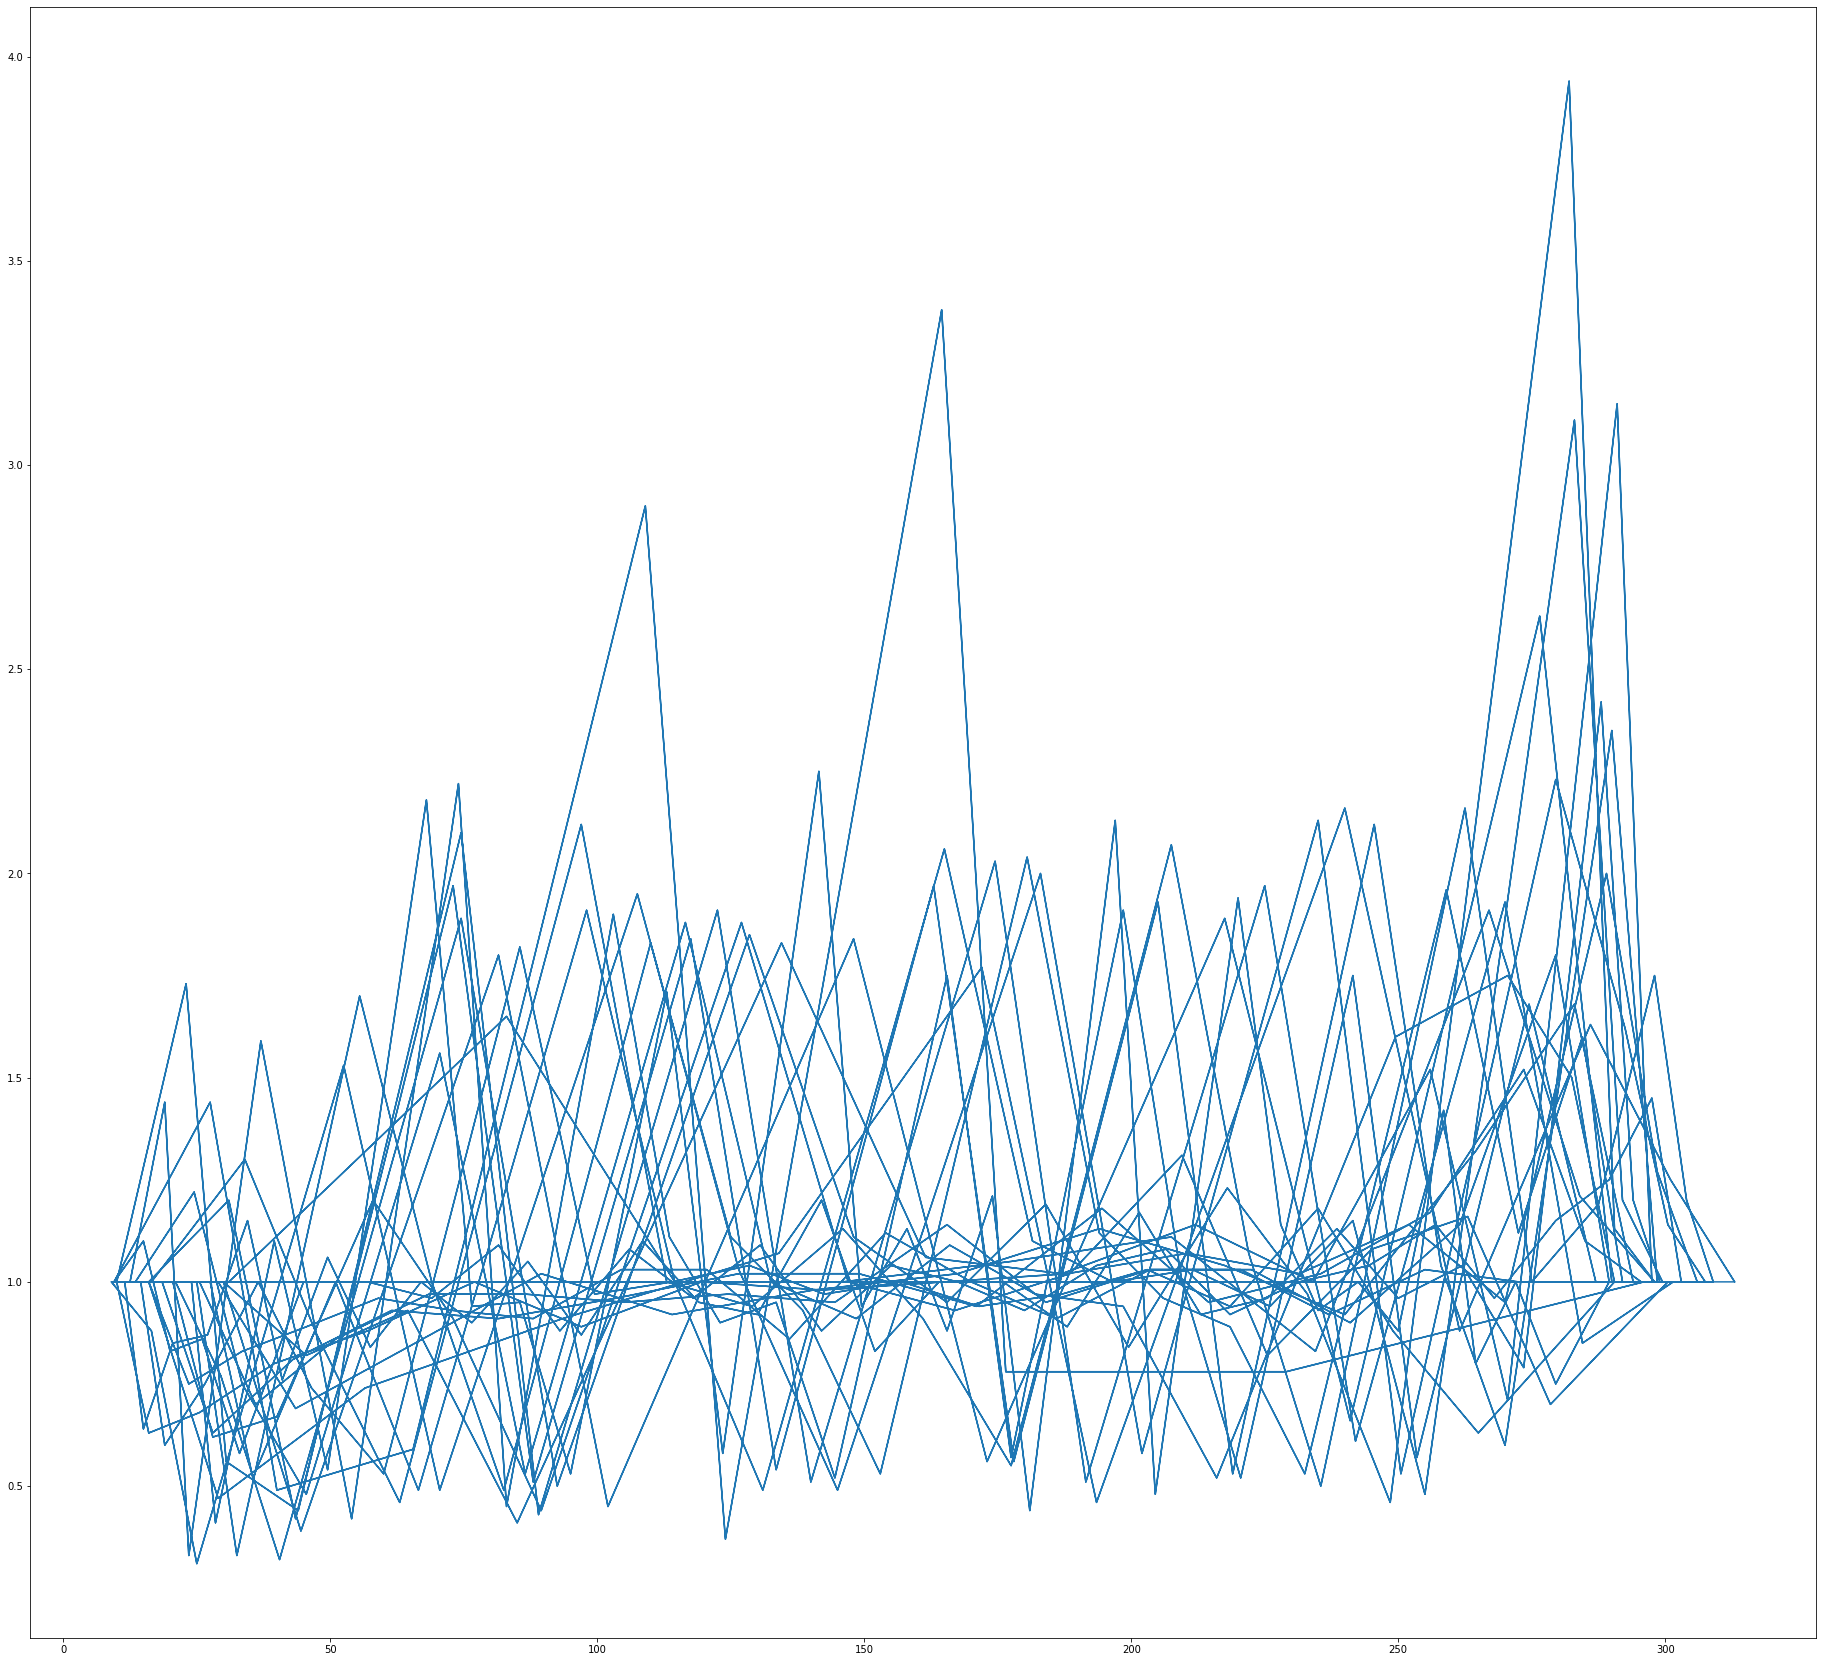

In [202]:
x,y = [],[]
for i in middle_seq_factor_r2l:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)

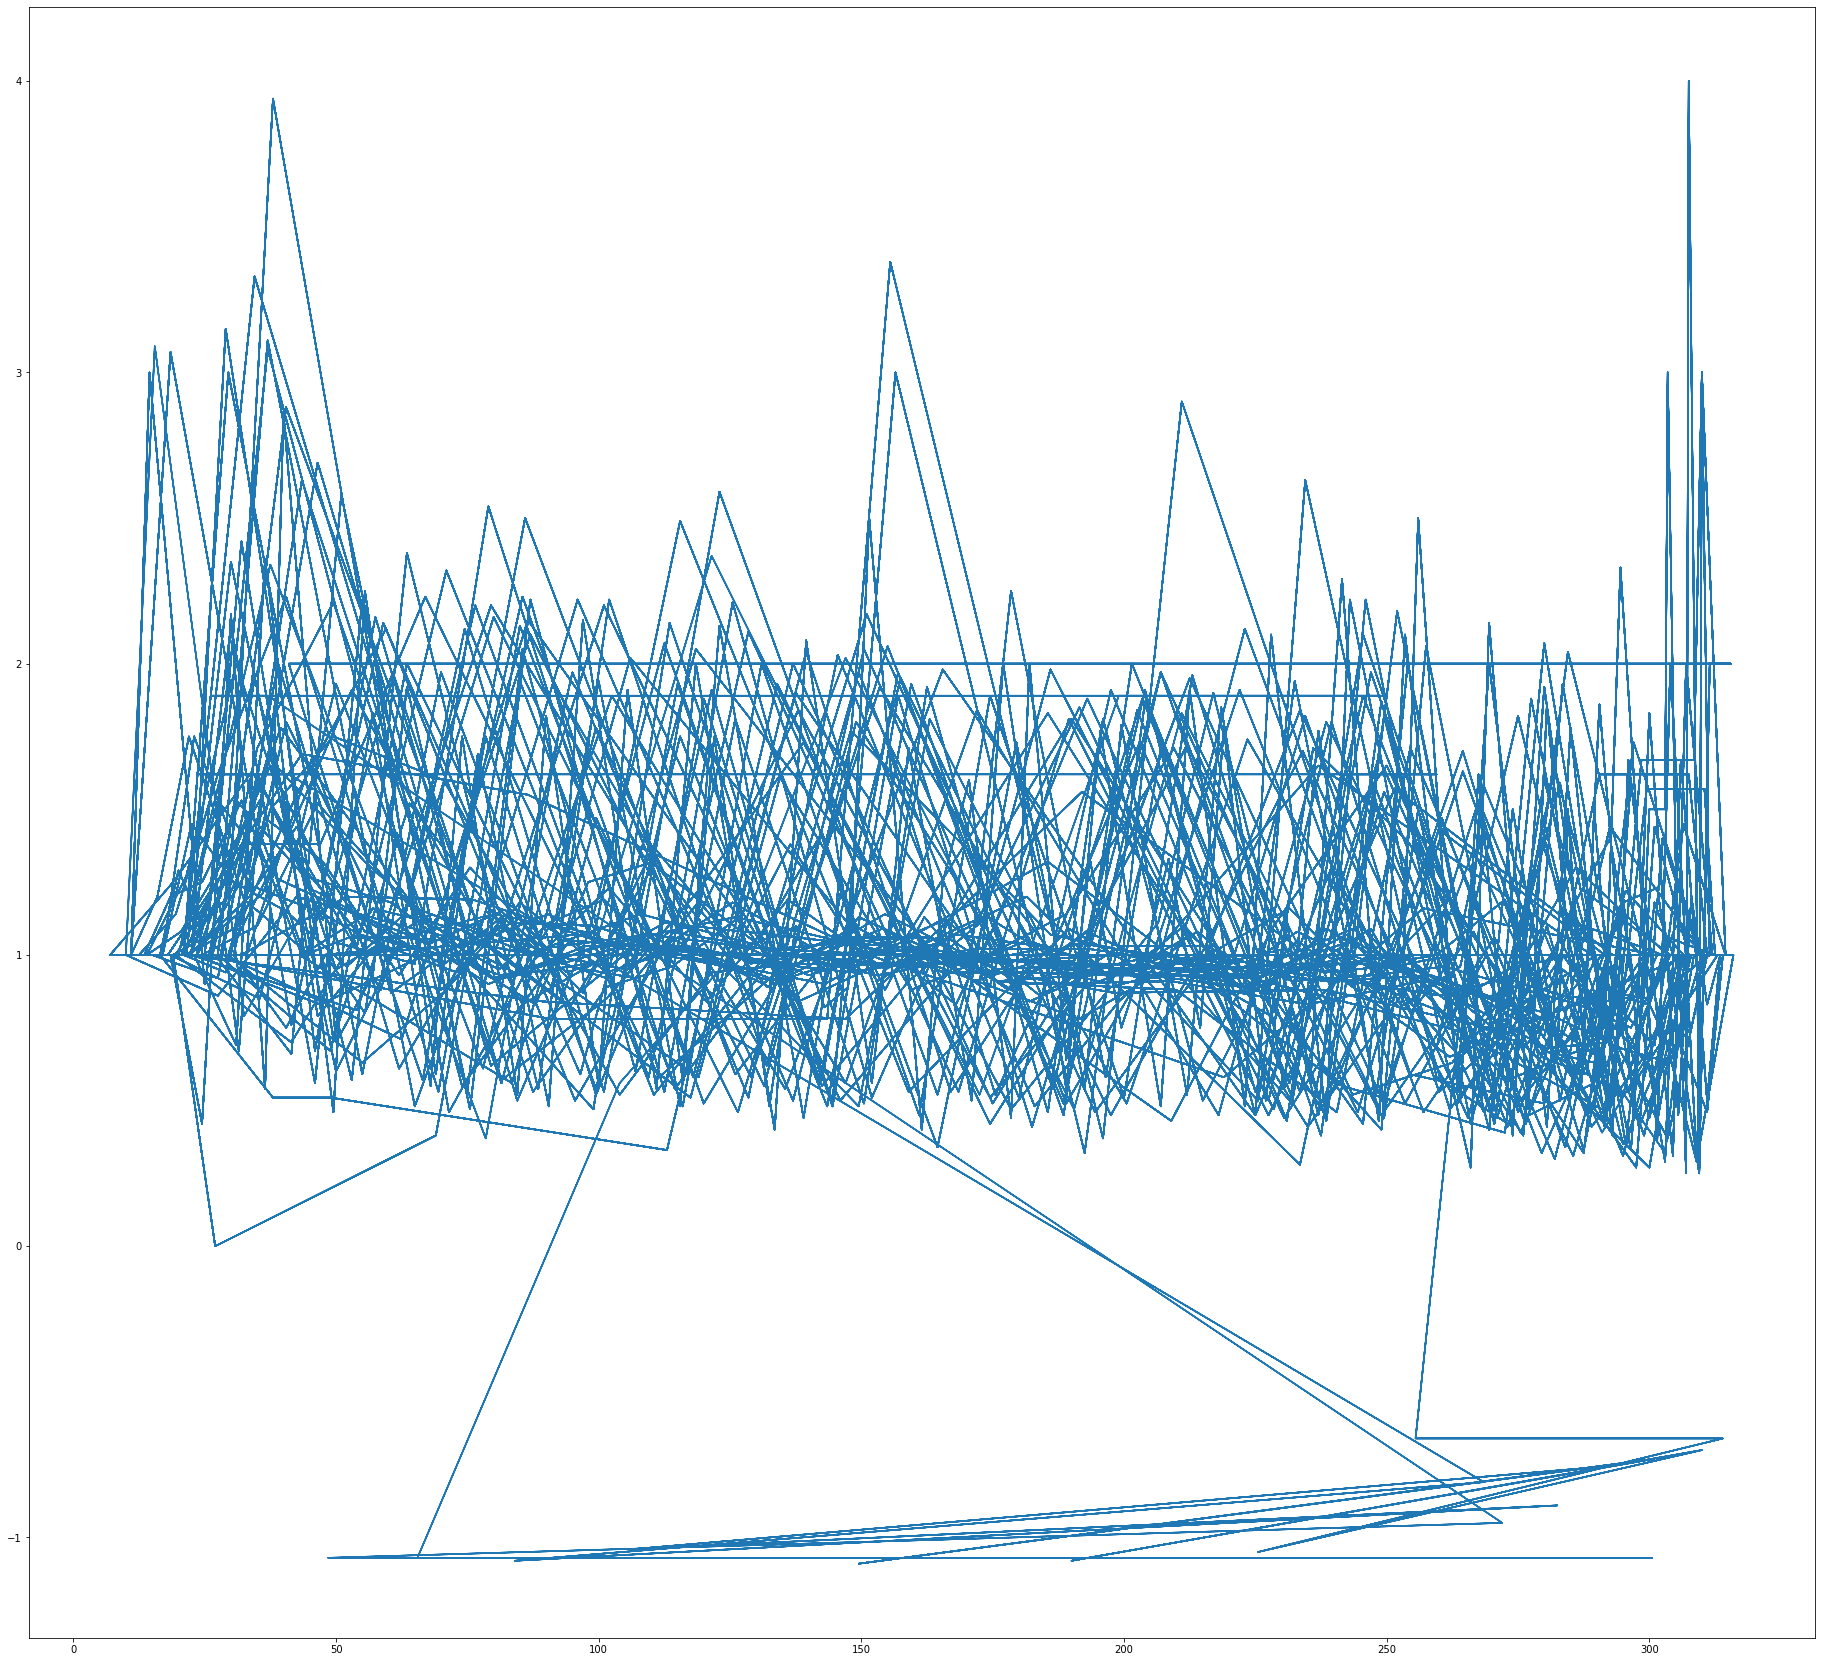

In [207]:
x,y = [],[]
for i in middle_seq_factor_l2r:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)

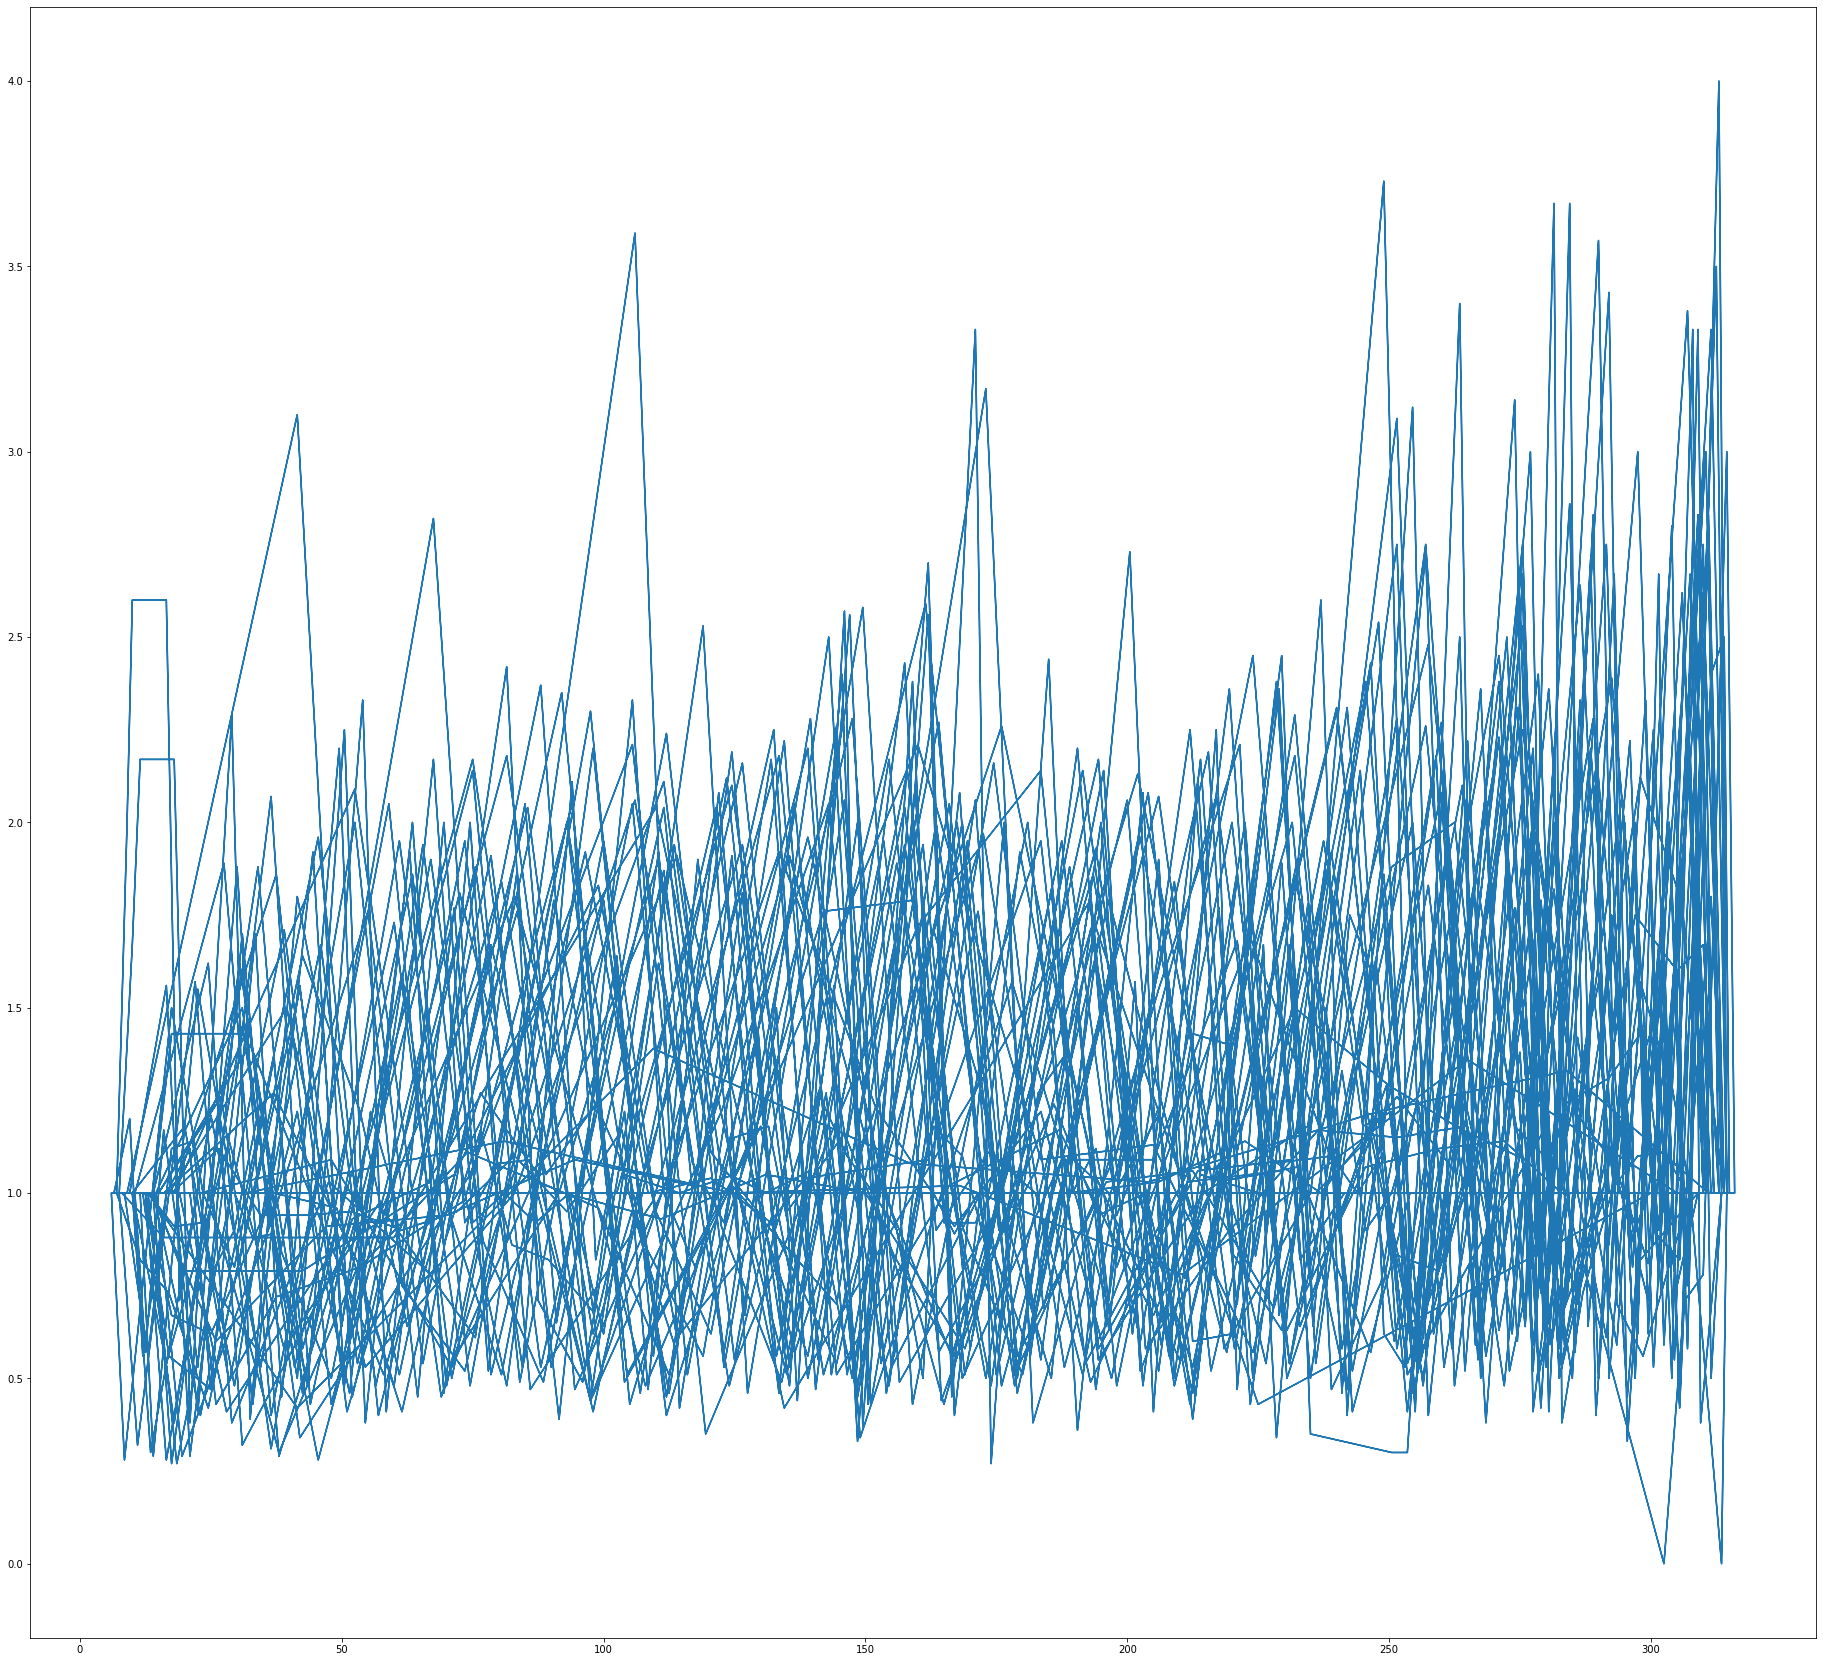

In [219]:
x,y = [],[]
for i in far_seq_factor_r2l:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)

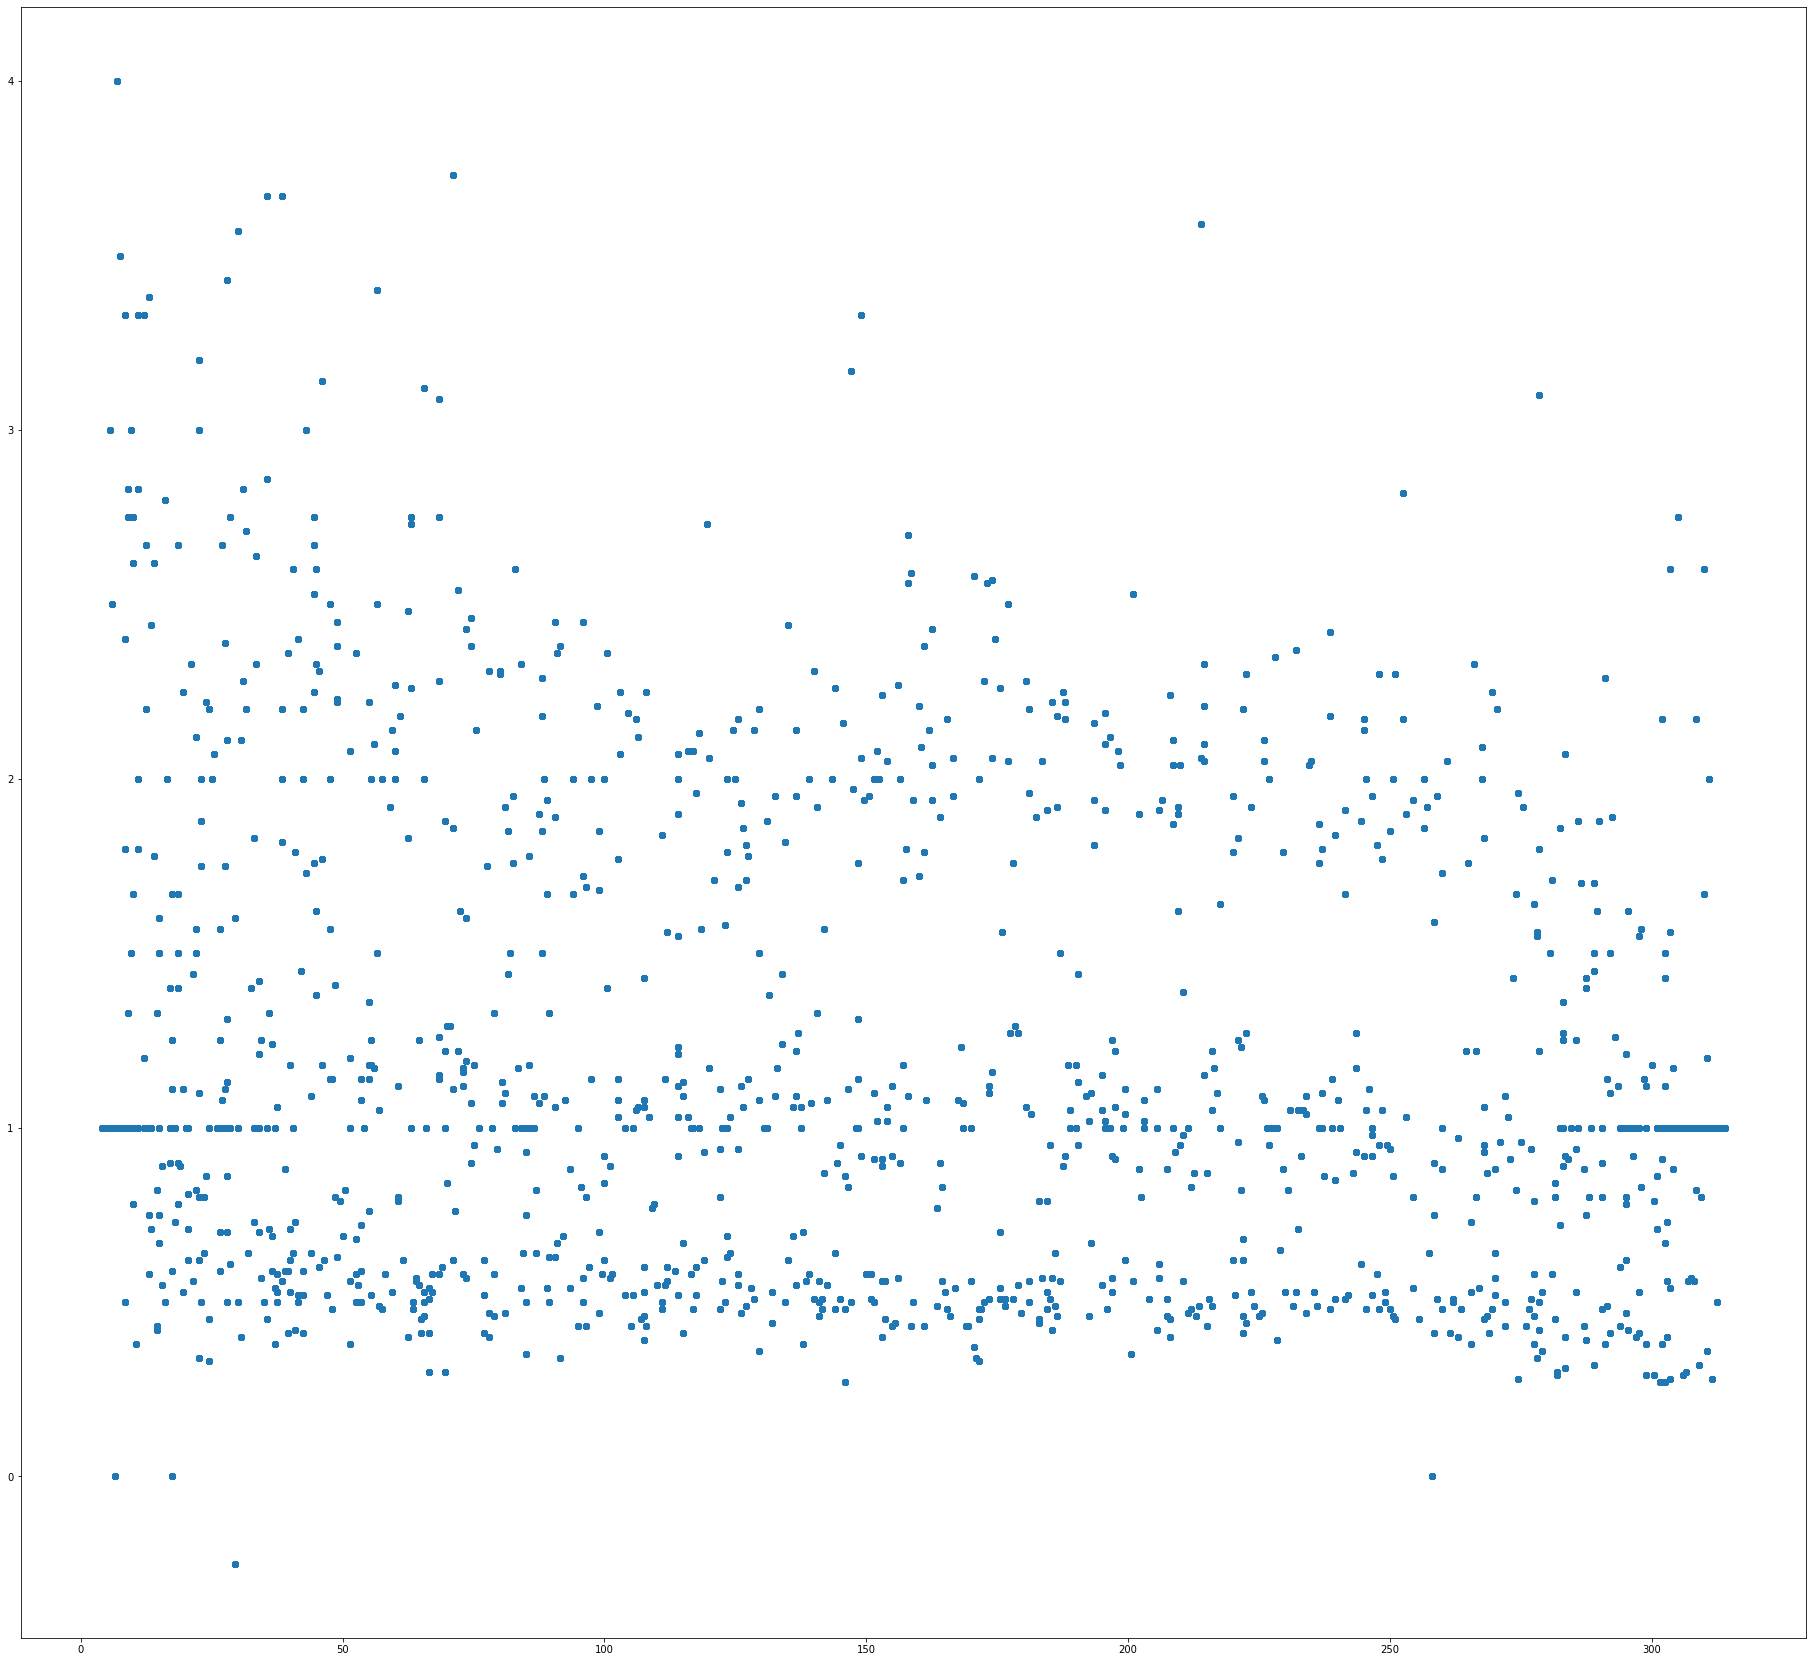

In [211]:
x,y = [],[]
for i in far_seq_factor_l2r:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.scatter(x,y)

In [222]:
#result of hypothesis2
# result of hypothesis 1
near_seq_factor_l2r_h2 = calculate_speedPosision_factor(near_seq_list_l2r,hypothesis='2')
middle_seq_factor_l2r_h2 = calculate_speedPosision_factor(middle_seq_list_l2r,hypothesis='2')
far_seq_factor_l2r_h2 = calculate_speedPosision_factor(far_seq_list_l2r,hypothesis='2')

near_seq_factor_r2l_h2 = calculate_speedPosision_factor(near_seq_list_r2l,hypothesis='2')
middle_seq_factor_r2l_h2 = calculate_speedPosision_factor(middle_seq_list_r2l,hypothesis='2')
far_seq_factor_r2l_h2 = calculate_speedPosision_factor(far_seq_list_r2l,hypothesis='2')

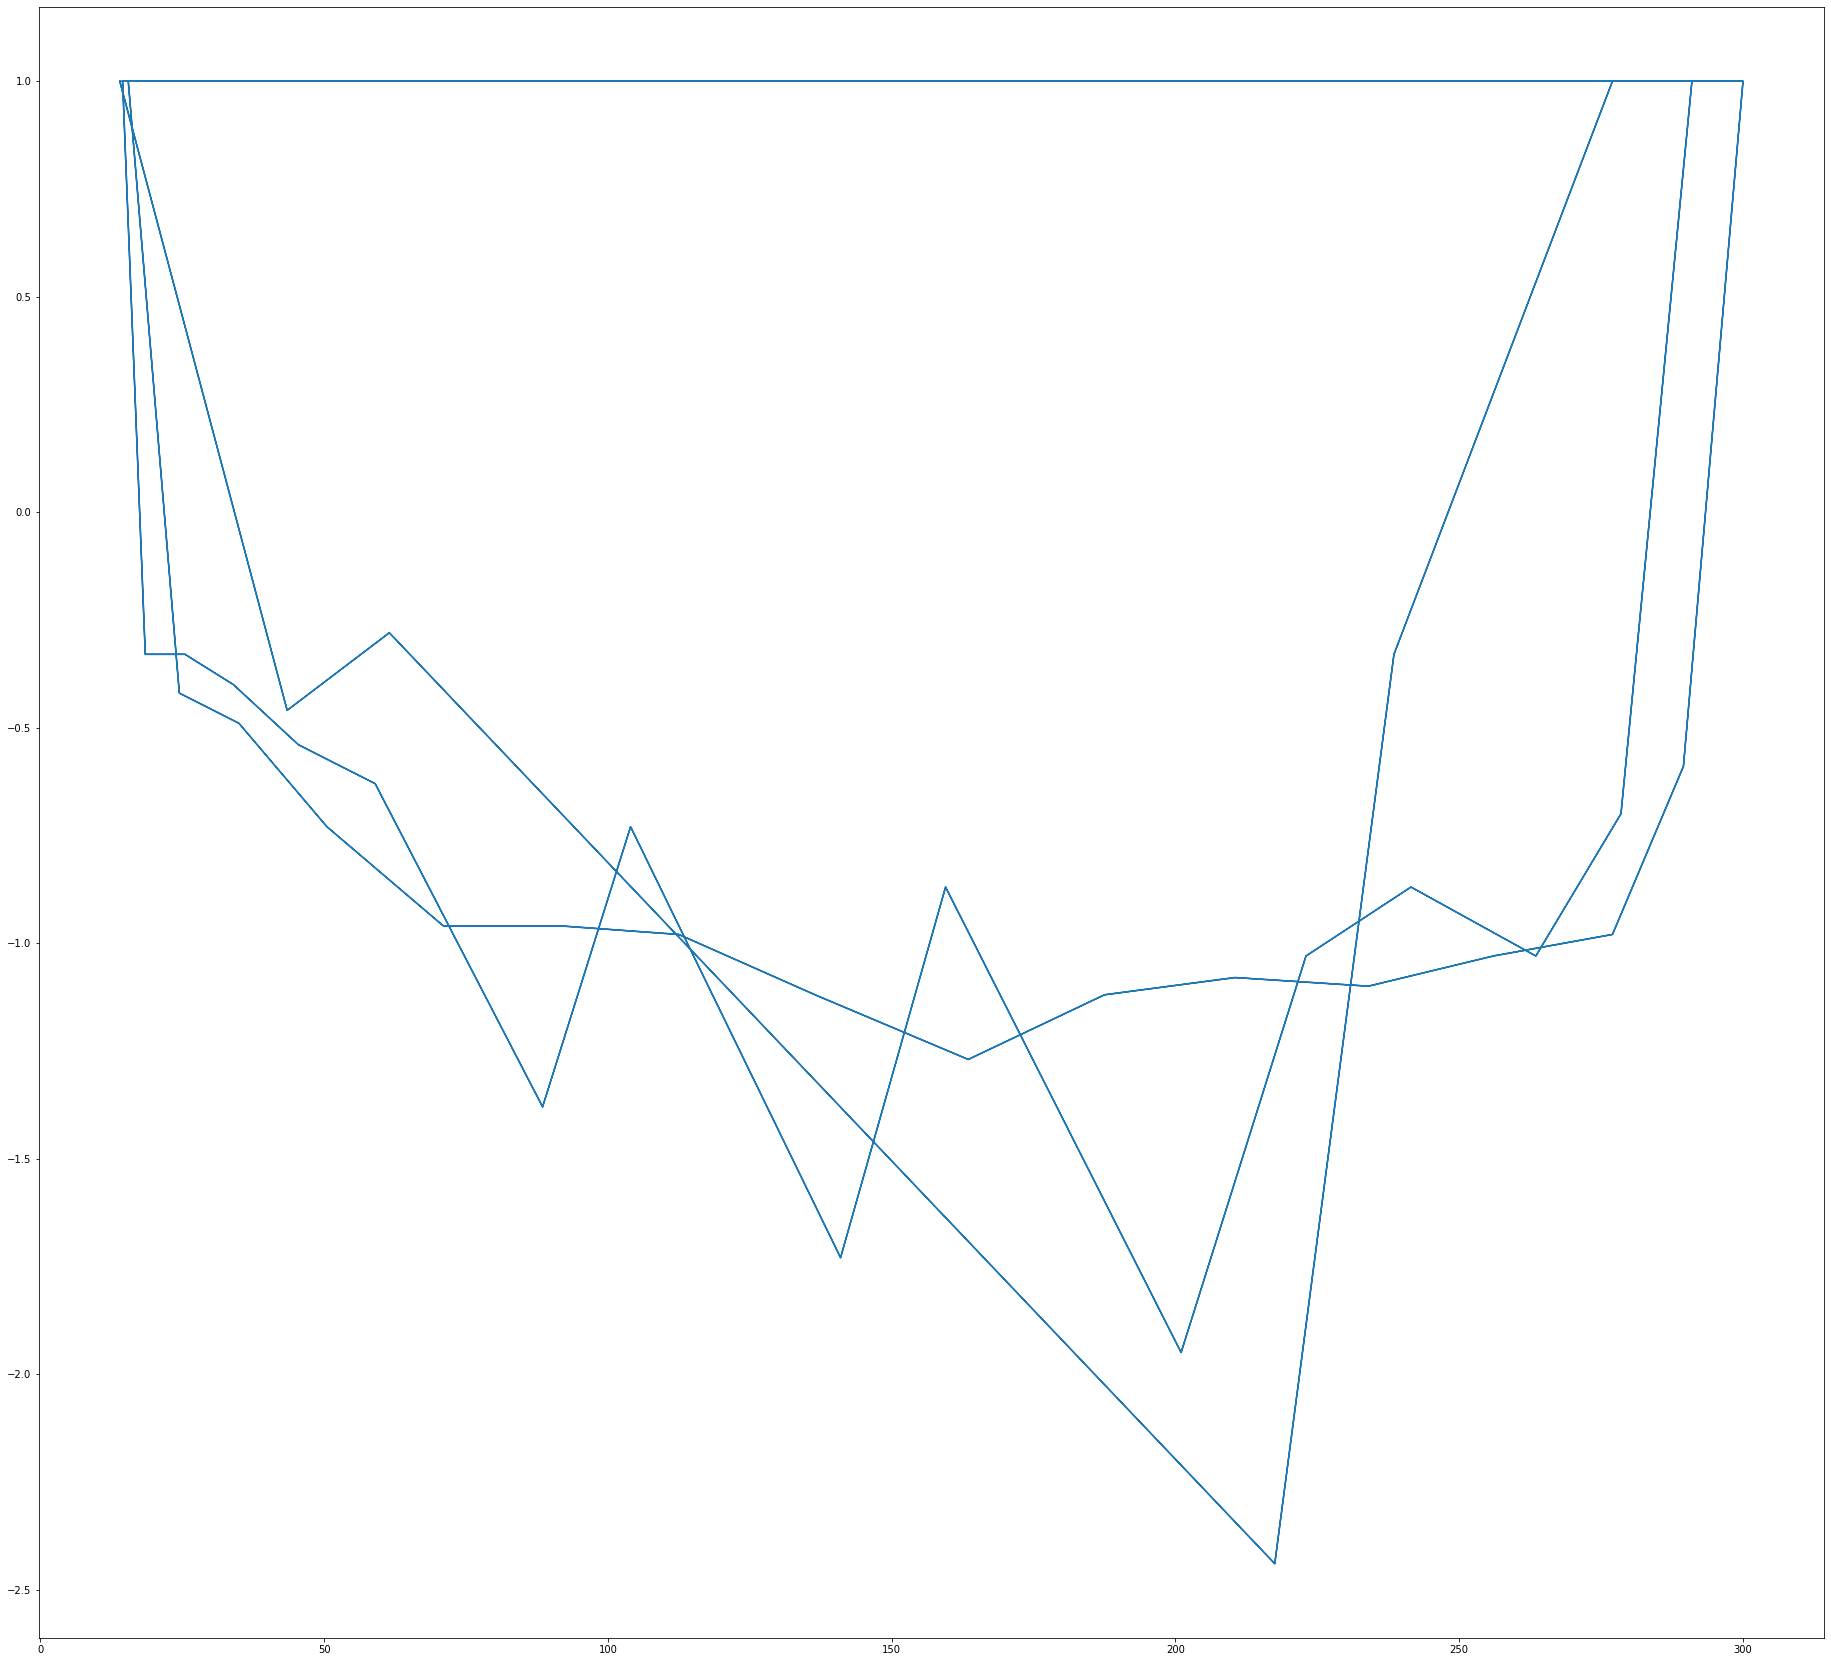

In [223]:
x,y = [],[]

for i in near_seq_factor_r2l_h2:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)

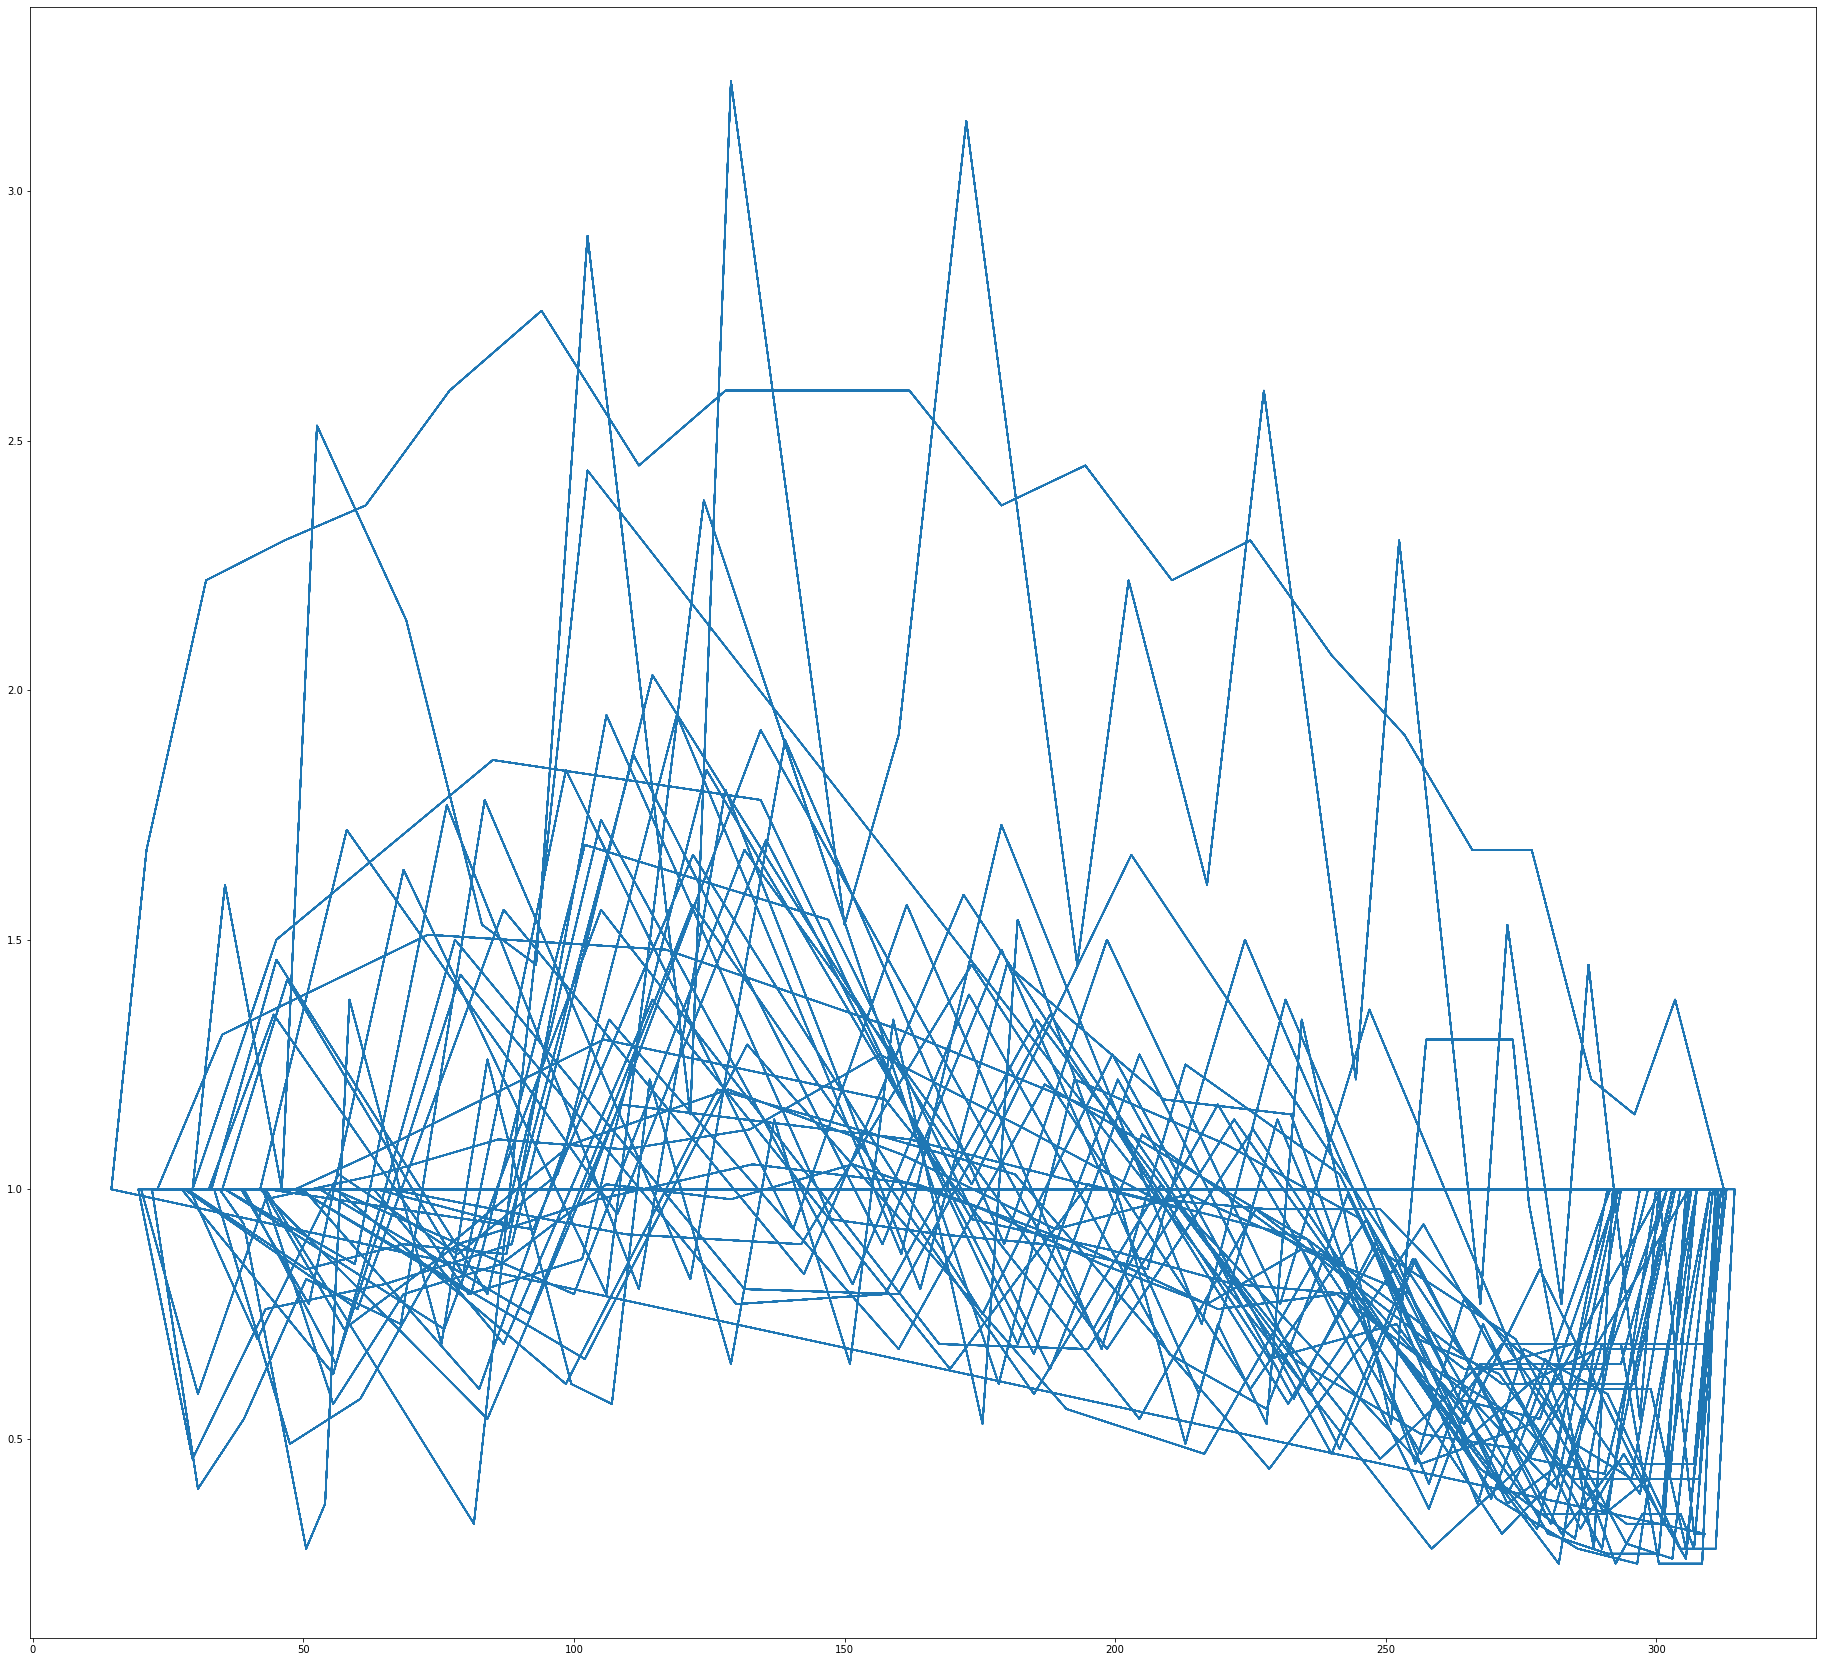

In [225]:
x,y = [],[]
for i in near_seq_factor_l2r_h2:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)

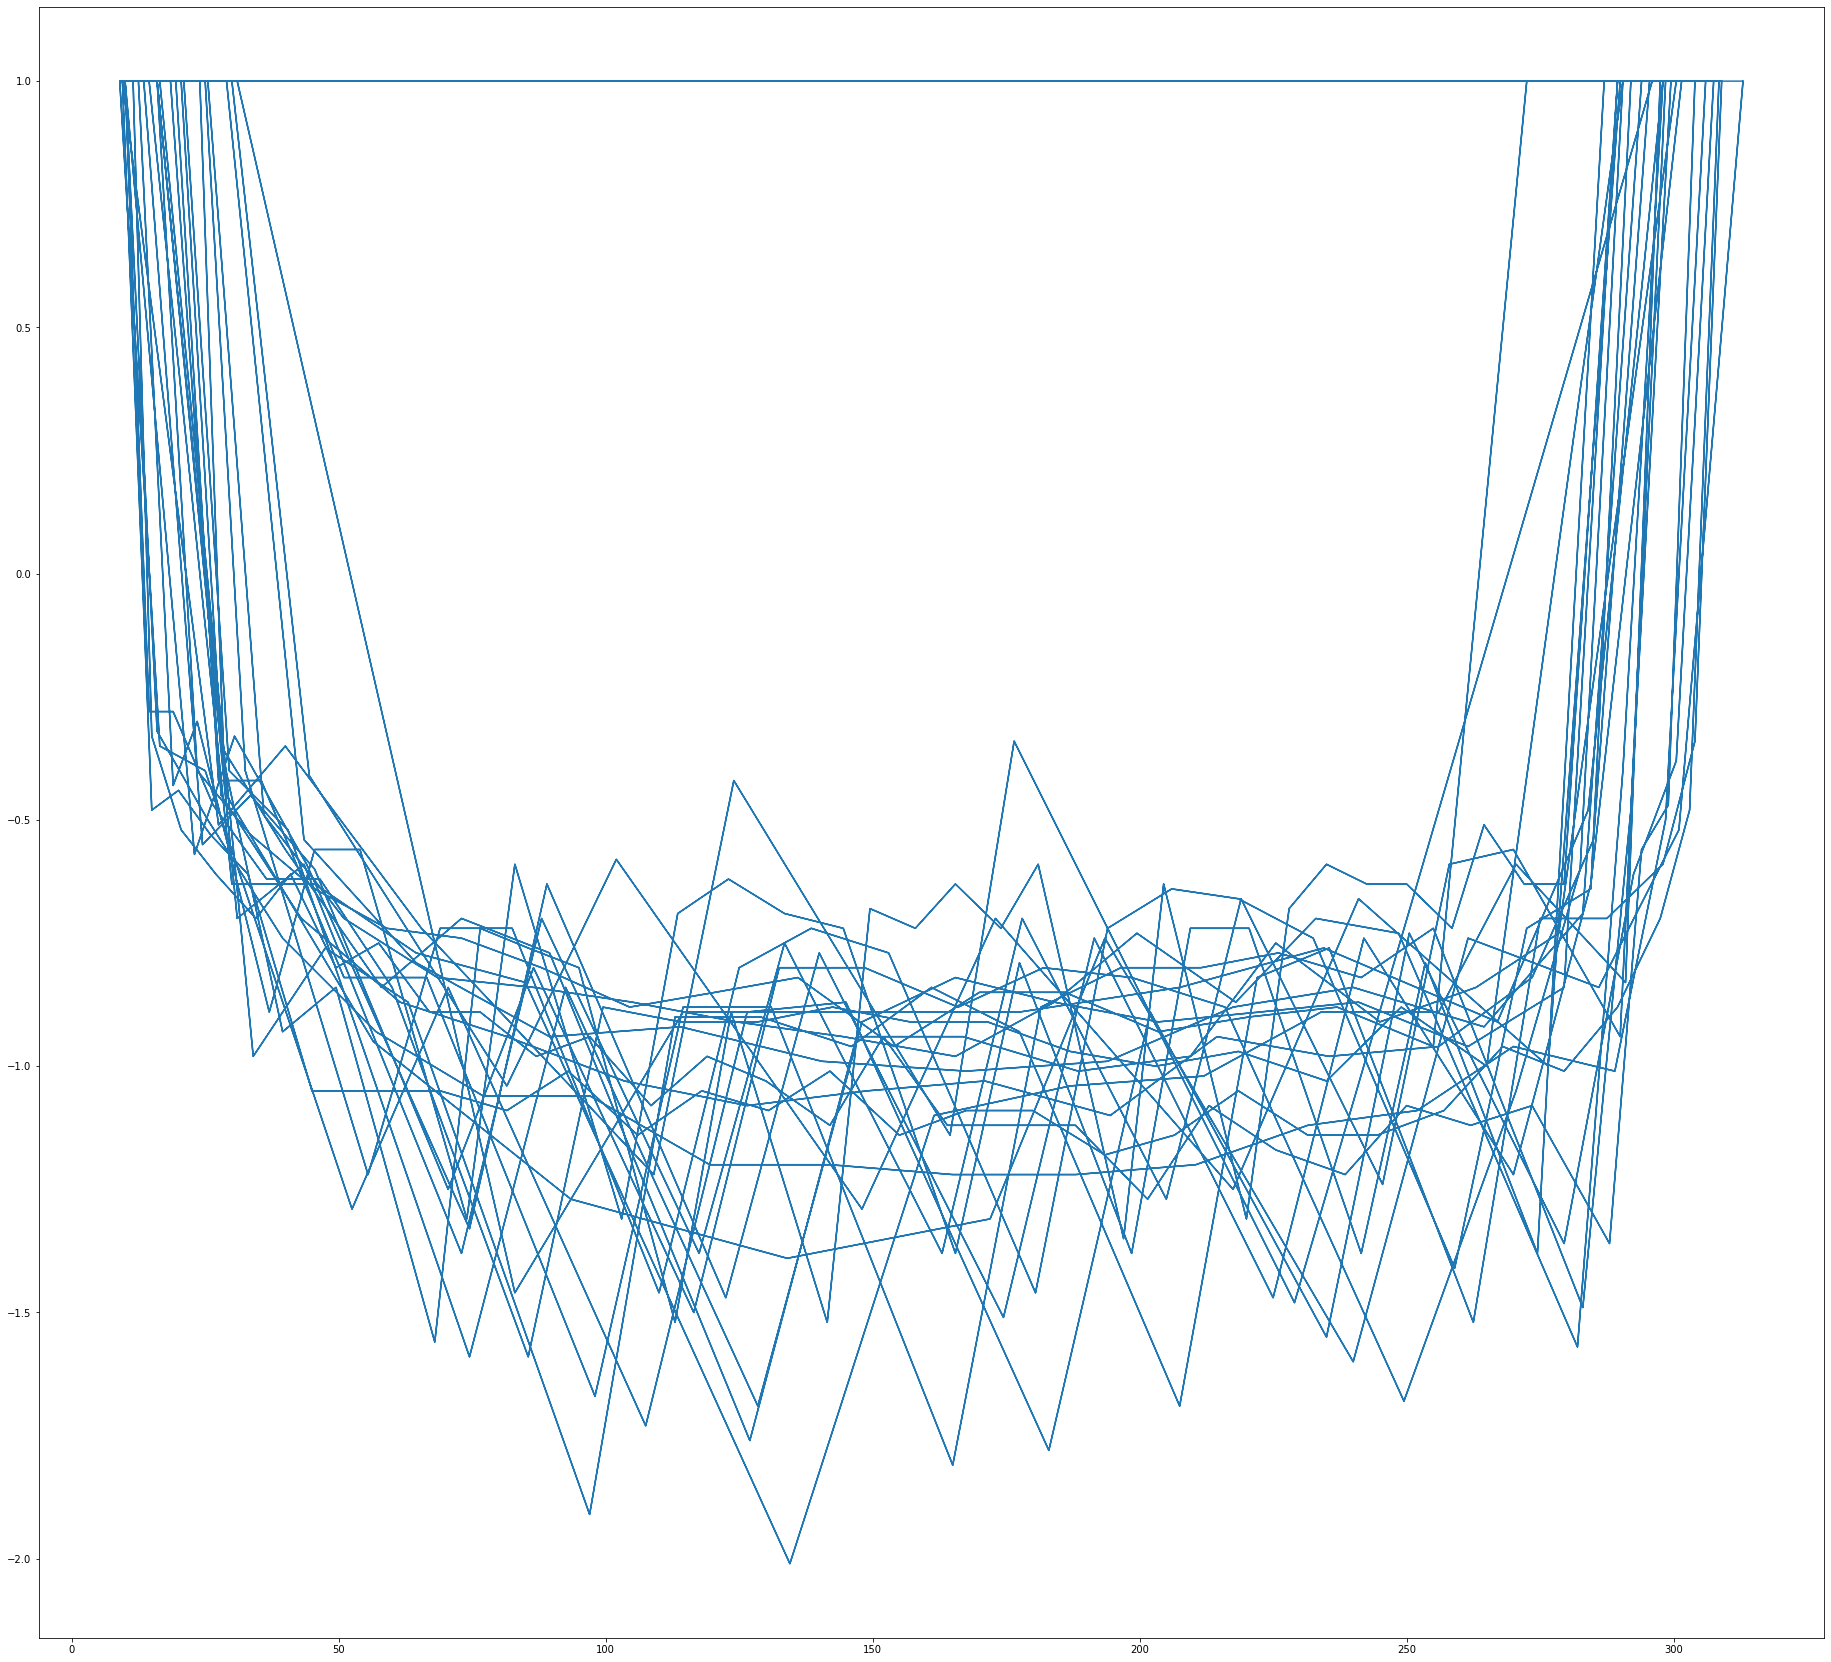

In [226]:
x,y = [],[]
for i in middle_seq_factor_r2l_h2:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)

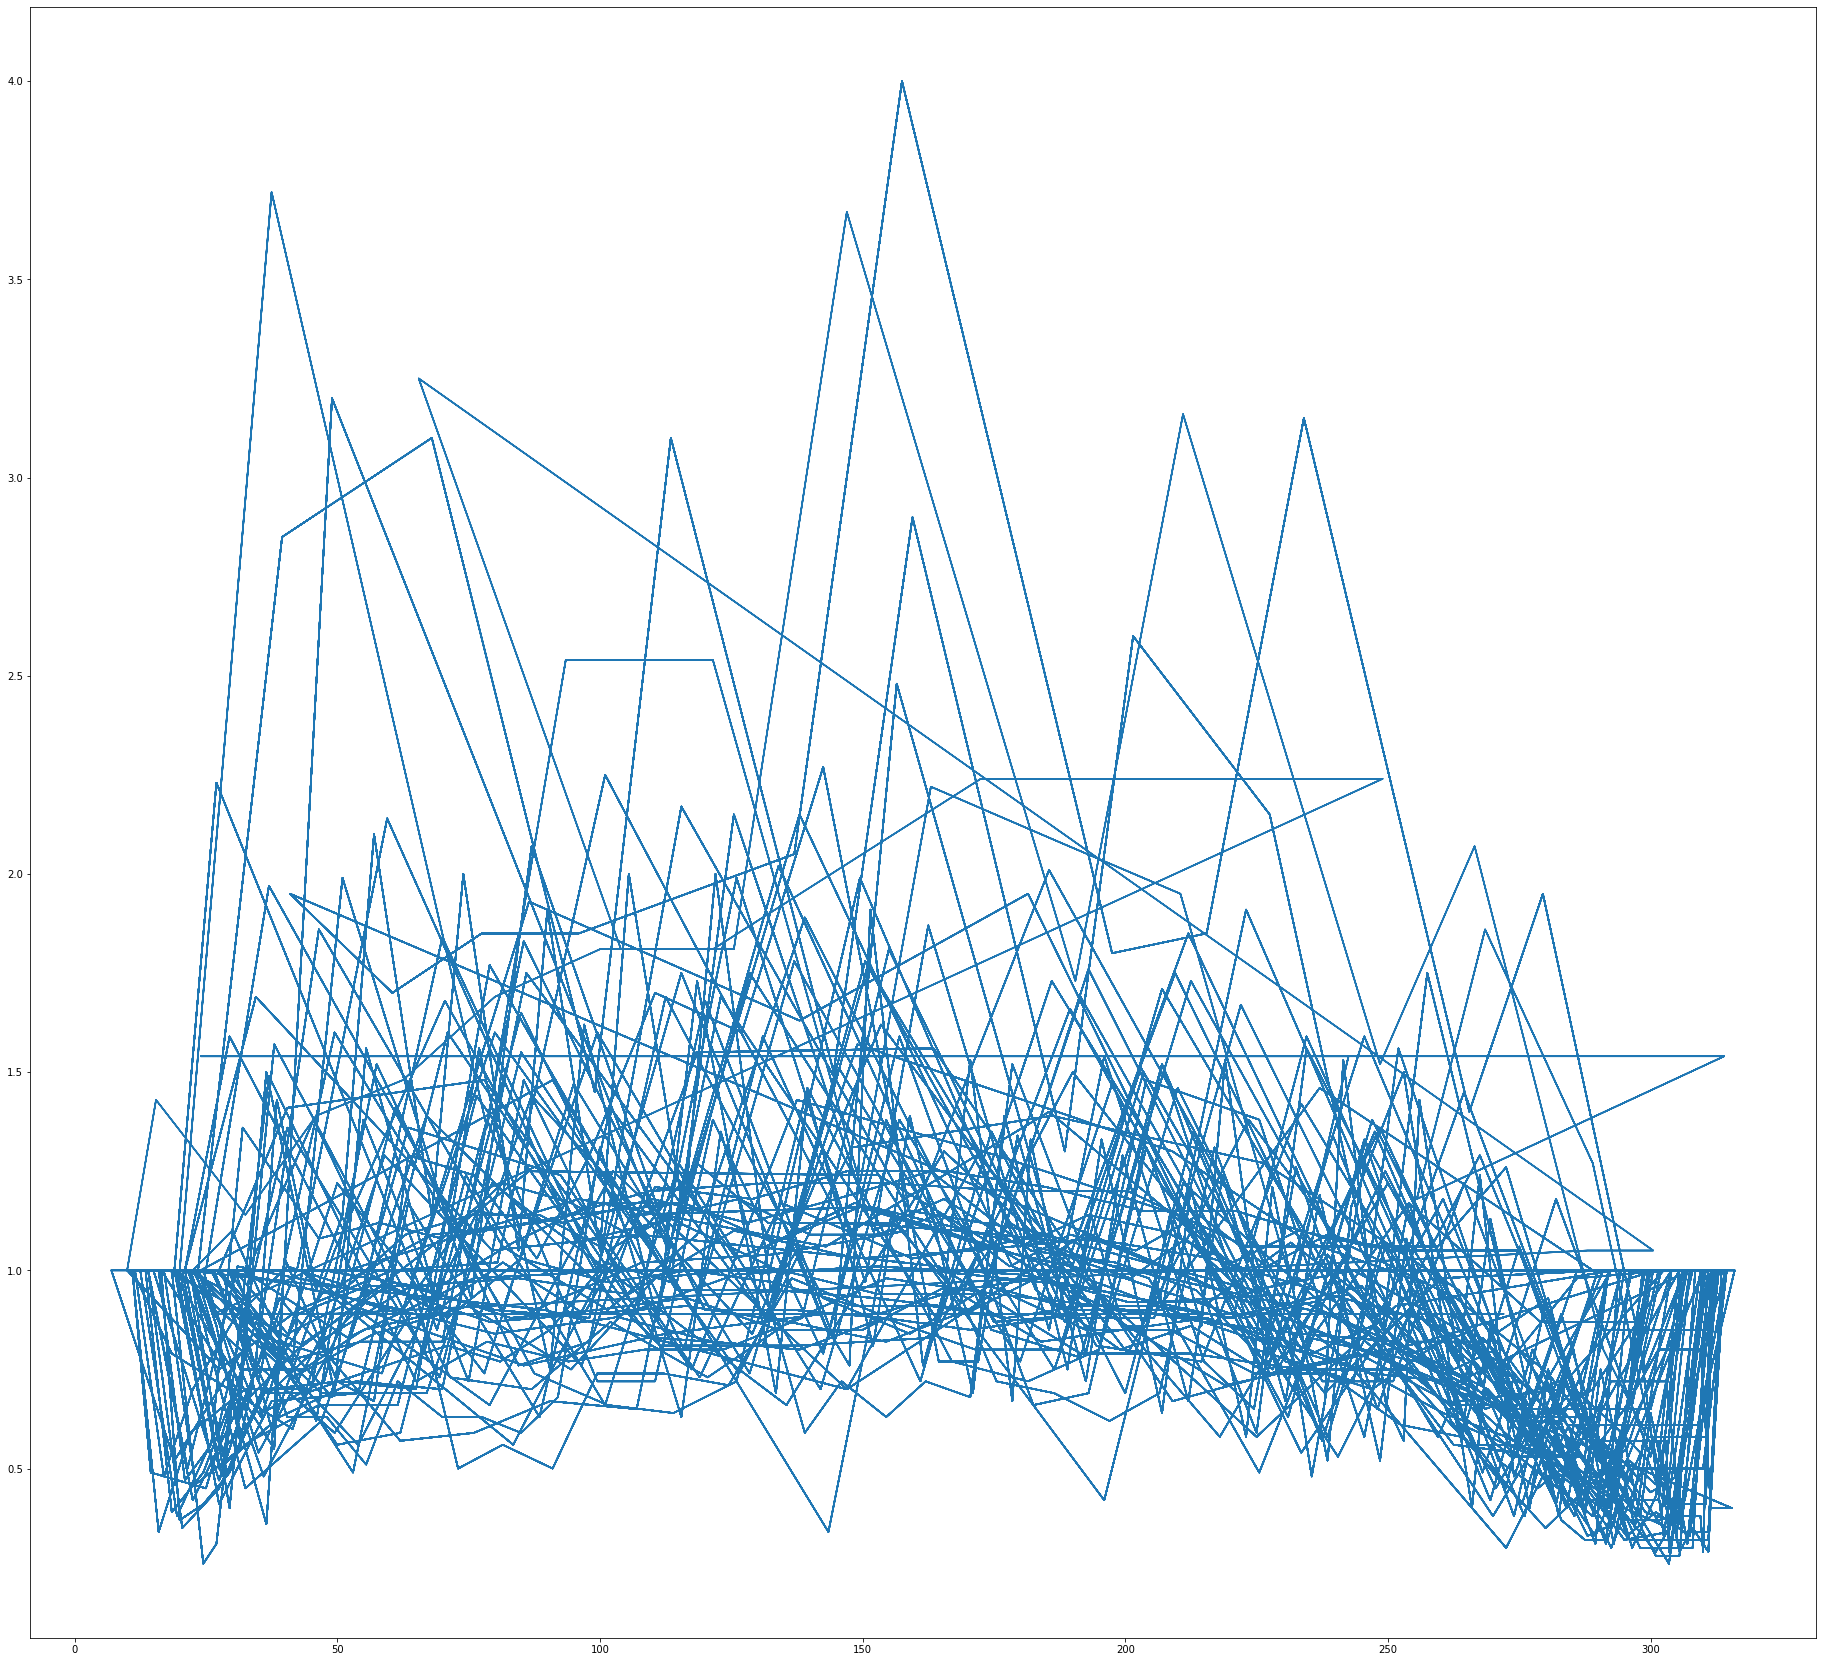

In [227]:
x,y = [],[]
for i in middle_seq_factor_l2r_h2:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)

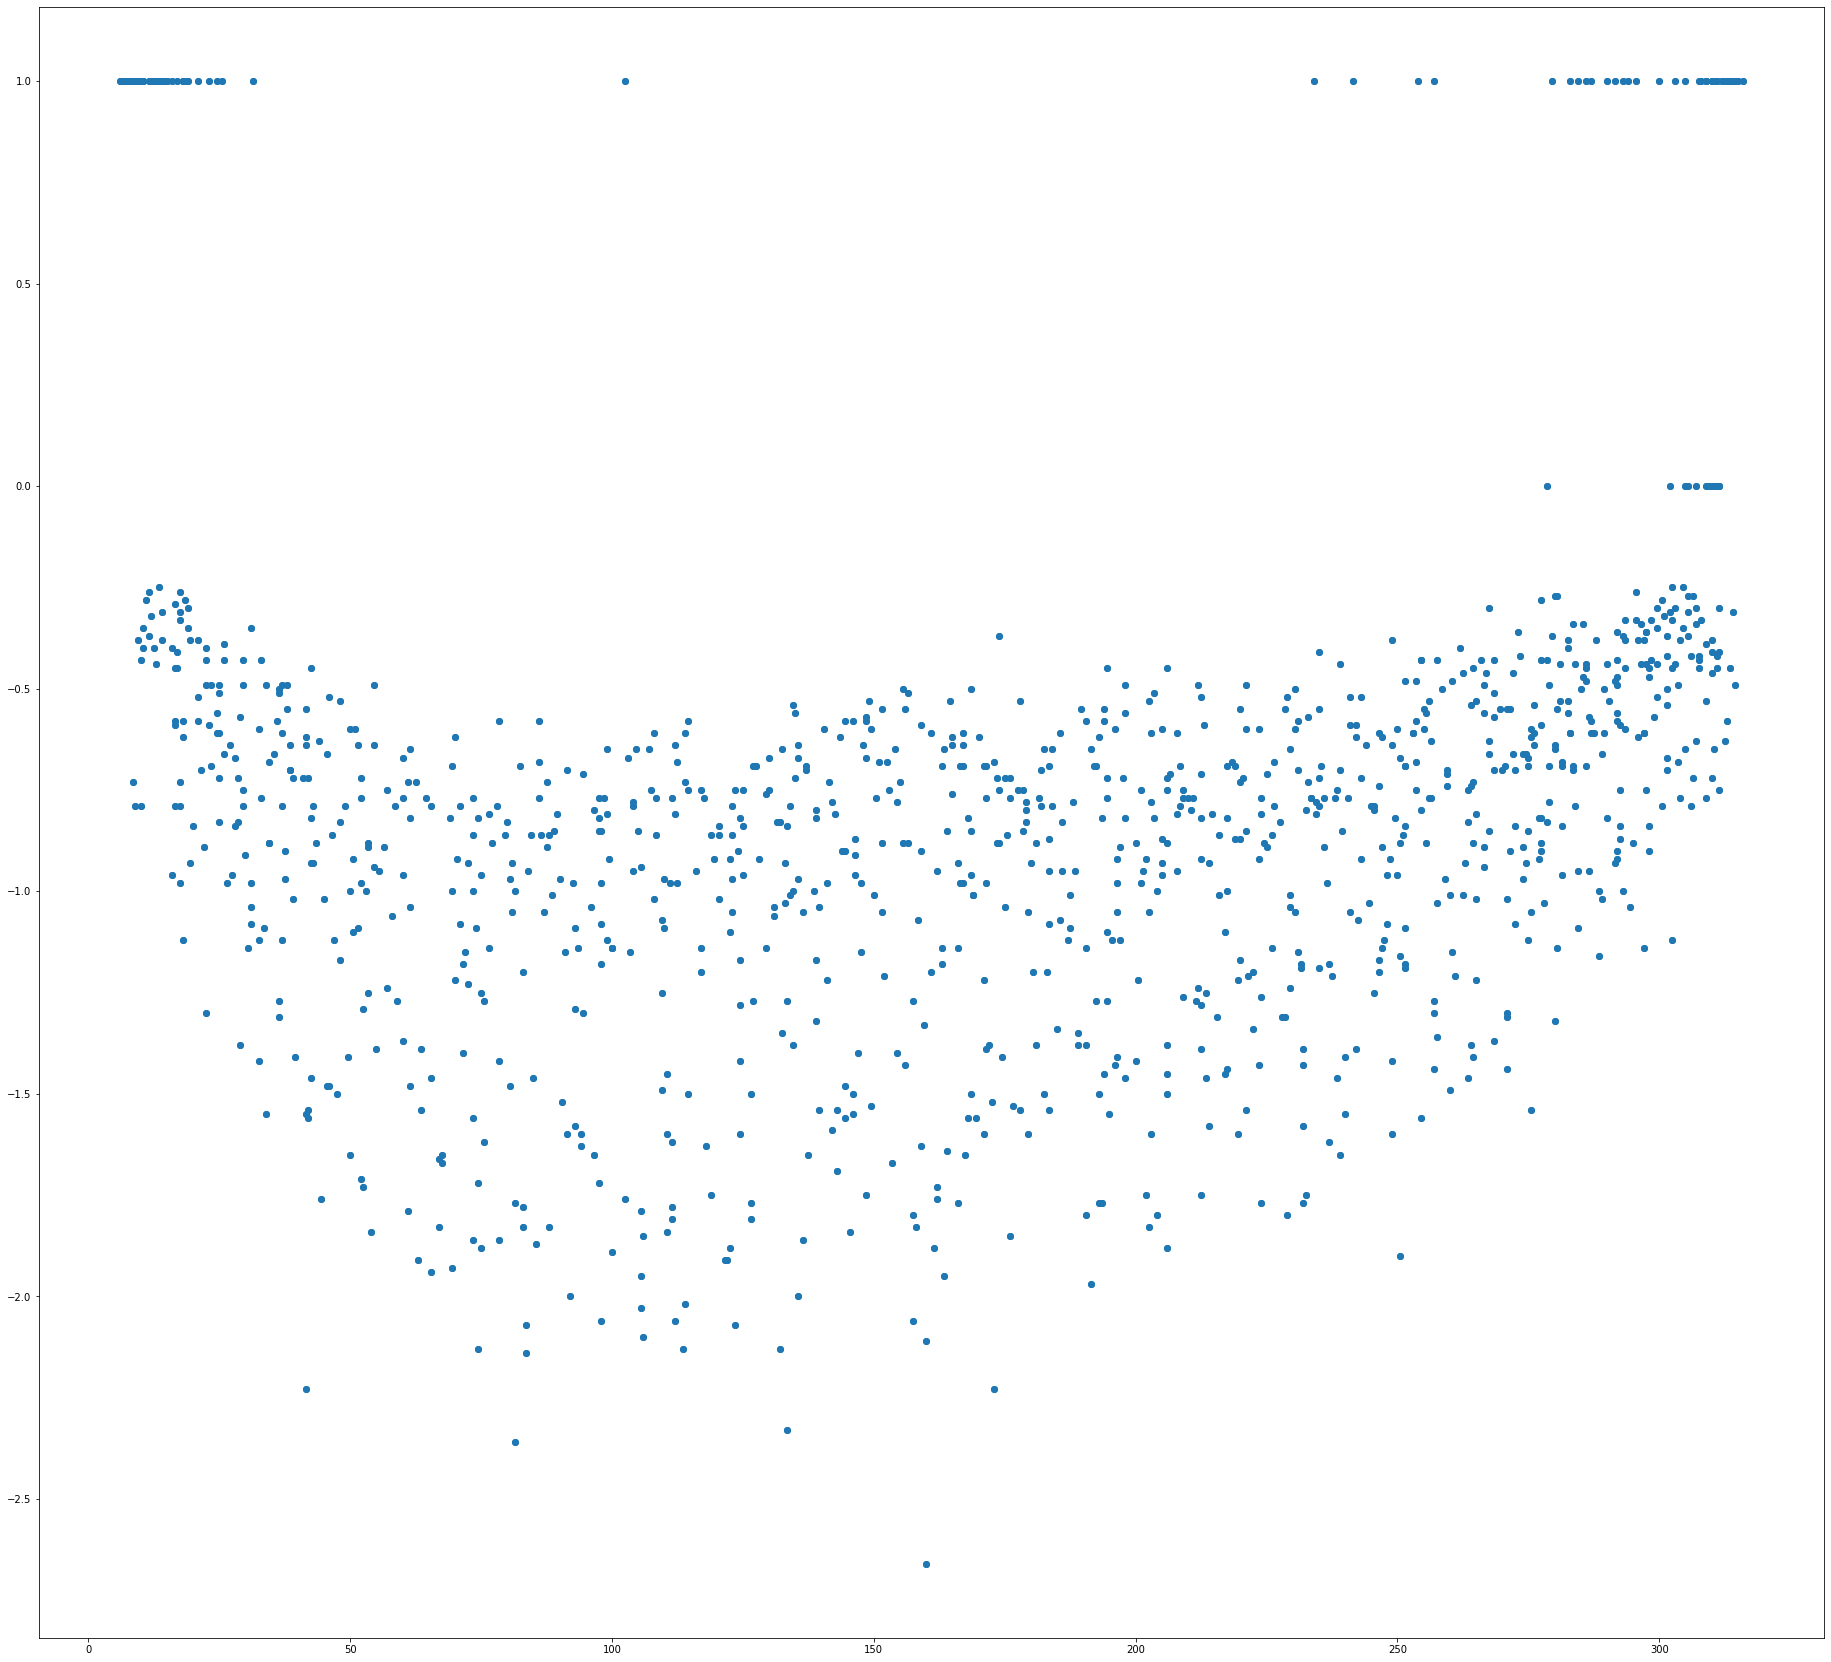

In [233]:
x,y = [],[]
for i in far_seq_factor_r2l_h2:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.scatter(x,y)

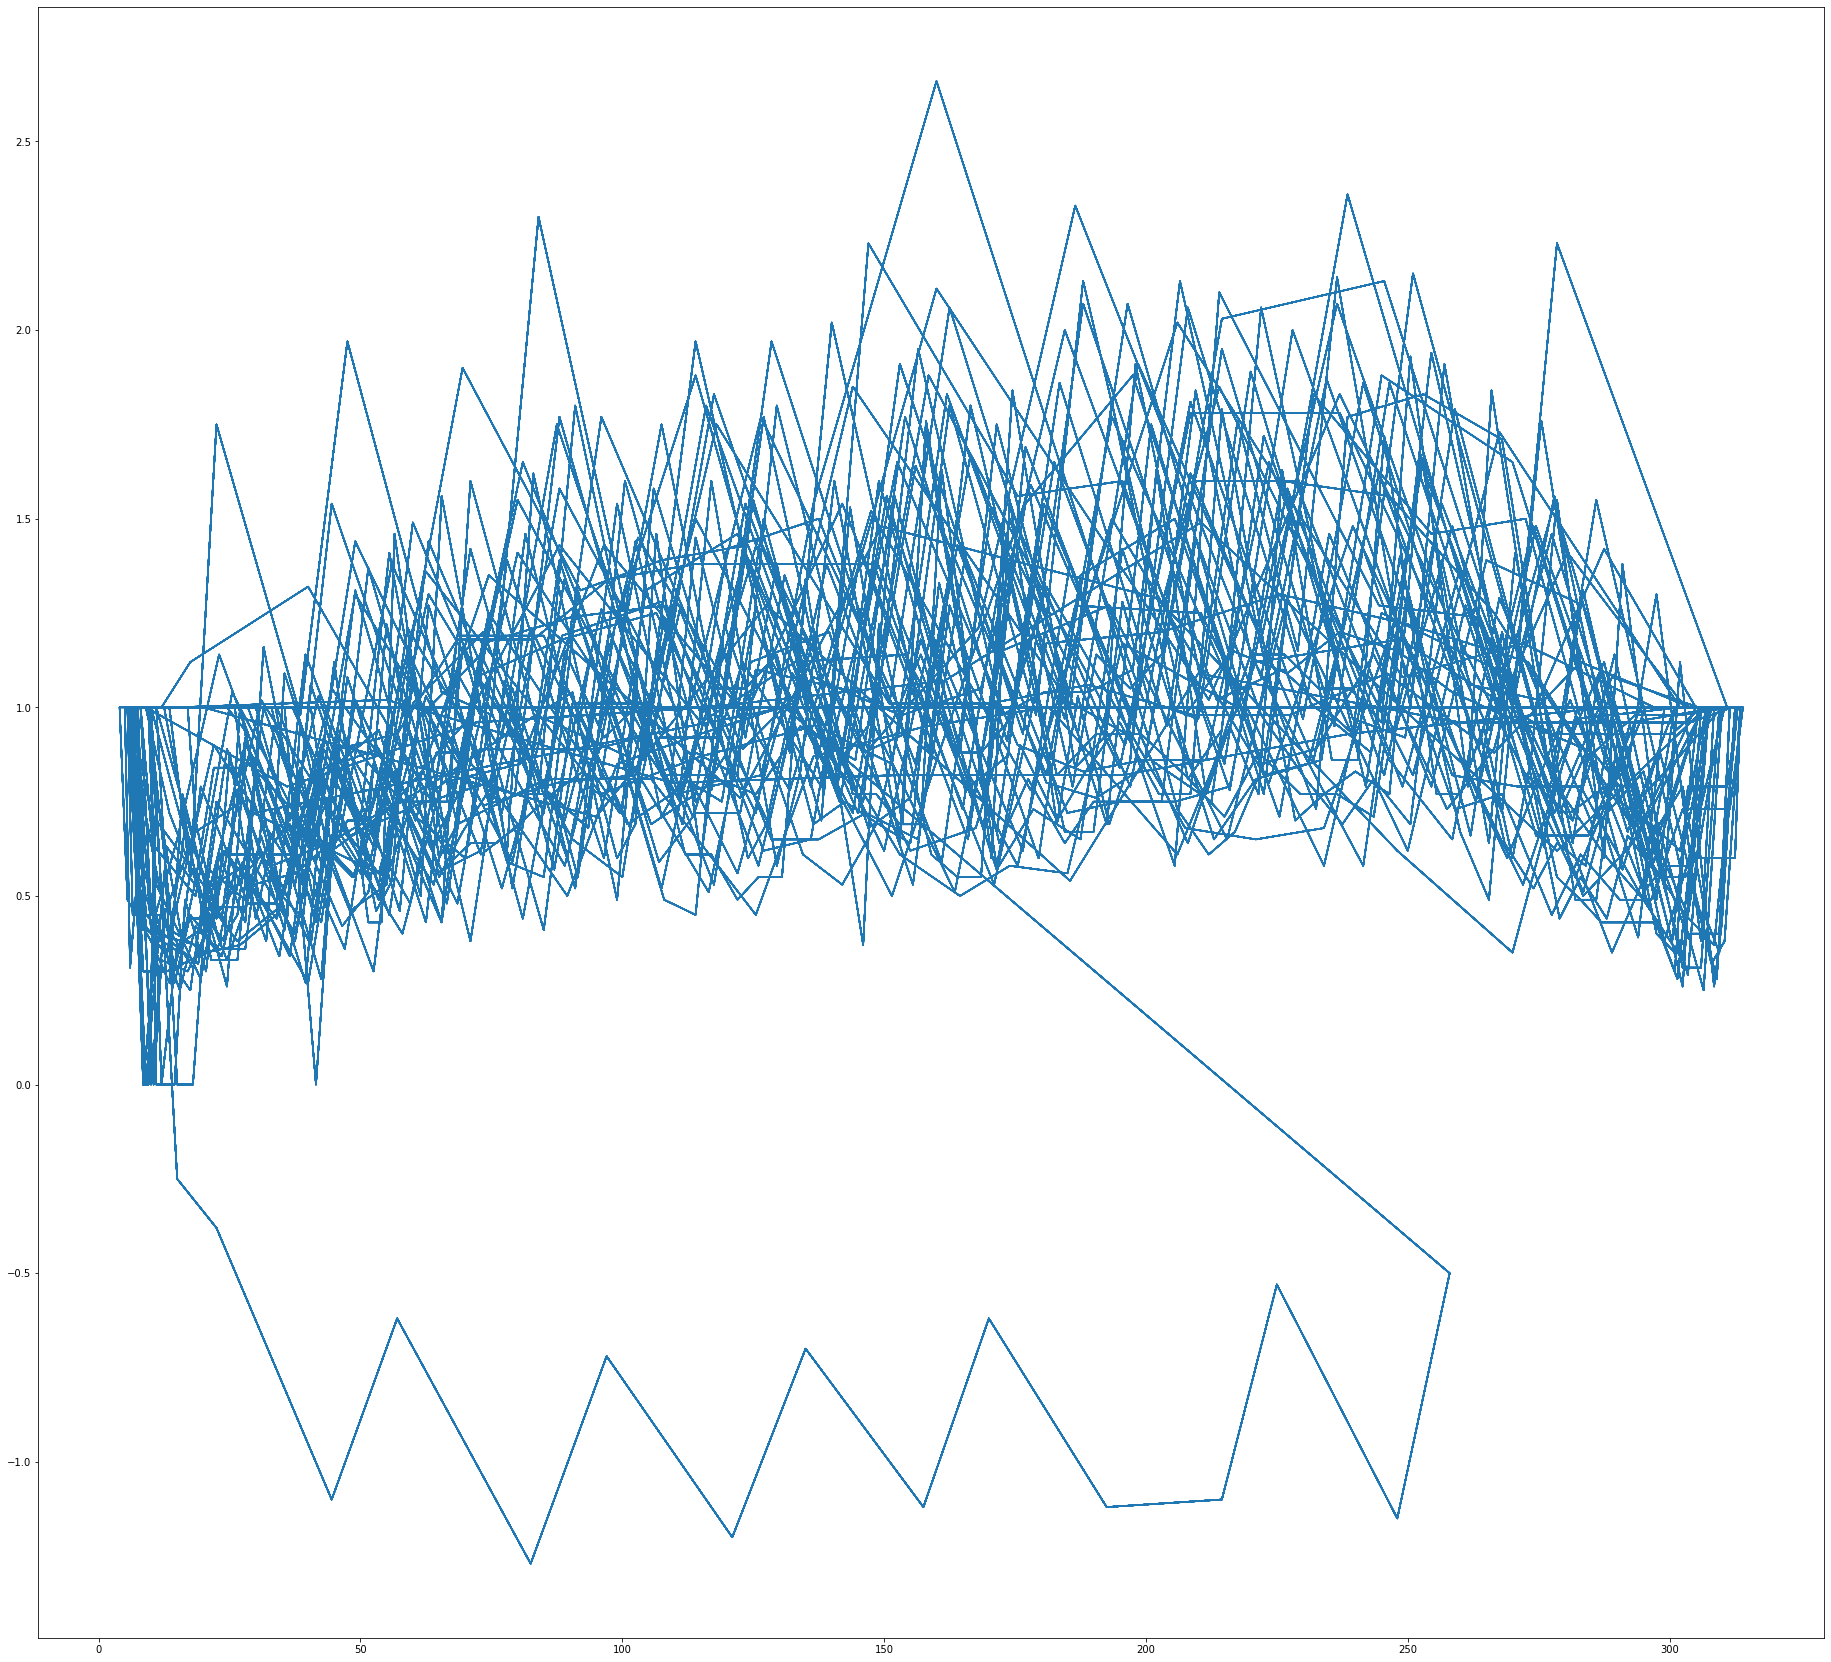

In [229]:
x,y = [],[]
for i in far_seq_factor_l2r_h2:
    for j in i:
        x.append(j[0])
        y.append(j[1])
#p = plt.scatter(x,y)
plt.figure(figsize=(32, 30))
p = plt.plot(x,y)